# 1. Importing librairies

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Librairies for EDA functions
#KNN 
from sklearn.impute import KNNImputer
#Encoding categorical variables
from sklearn.preprocessing import OneHotEncoder
#Centering and standardising
from sklearn.preprocessing import StandardScaler

#Librairies for models testing
#Train test split
from sklearn.model_selection import train_test_split

#Understanding the model and its performances

#Import Linear model librarie
from sklearn.linear_model import LinearRegression

#Import grid search library
from sklearn.model_selection import GridSearchCV, KFold

#Displaying the mean squared error
from sklearn.metrics import mean_squared_error
#Displaying the coefficient of determination
from sklearn.metrics import r2_score
#Calculating the p value
from scipy import stats

#Lasso
from sklearn.linear_model import Lasso

#Import Random Forest libraries
from sklearn.ensemble import RandomForestRegressor
#Random forest features selection 
from sklearn.feature_selection import SelectFromModel
#Accuracy score
from sklearn.metrics import accuracy_score
#Processing time
import timeit
#Cross Validation
from sklearn.model_selection import cross_val_score

#Gradient Boosting
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import uniform, randint

#SVR
from sklearn.svm import SVR, LinearSVR

#SHapley Additive exPlanations
import shap
from IPython.display import display

# 2. Applying functions

In [2]:
def all_treatments(df):
    #Deleting non residential buildings
    df = df.loc[df['BuildingType'].str.contains("NonResidential|Nonresidential COS|SPS-District K-12|Campus|Nonresidential WA")]
    #Deleting the Residence Halls
    df = df.loc[df['PrimaryPropertyType'] != 'Residence Hall']
    #Deleting Senior Care Community
    df = df.loc[df['PrimaryPropertyType'] != 'Senior Care Community']
    #Deleting Low-Rise Multifamily
    df = df.loc[df['PrimaryPropertyType'] != 'Low-Rise Multifamily']
    #Dropping unecessary columns
    df = df.drop(columns = ['OSEBuildingID','DataYear','Comments','City','State','TaxParcelIdentificationNumber'])
    #Turning 0s into 1 for the number of buildings
    df.loc[df['NumberofBuildings'] == 0, ['NumberofBuildings']] = 1
    #Deleting properties above 30 buildings
    df = df.loc[df['NumberofBuildings'] < 30]
    #Deleting the chinese baptist church
    df = df.loc[df['PropertyName'] != 'Seattle Chinese Baptist Church']
    
    #Deleting outliers in LargestPropertyUseTypeGFA
    df = df.loc[df['PropertyName'] != 'Entire Campus']
    df = df.loc[df['PropertyName'] != 'Columbia Center - 2015']
    df = df.loc[df['PropertyName'] != 'Swedish First Hill']
    df = df.loc[df['PropertyName'] != 'CenturyLink']

    #Deleting outliers in SecondLargestPropertyUseTypeGFA
    df = df.loc[df['PropertyName'] != 'Washington State Convention Center']
    df = df.loc[df['PropertyName'] != 'Plant 2 Site']

    #Deleting outliers in ThirdLargestPropertyUseTypeGFA
    df = df.loc[df['PropertyName'] != 'Russell Investments Center']
    
    #Deleting wheather normalized variables
    df = df.drop(columns = ['SiteEUIWN(kBtu/sf)','SourceEUIWN(kBtu/sf)','SiteEnergyUseWN(kBtu)'])

    #Deleting buildings with default data
    df = df.loc[df['DefaultData'] == False]
    #Deleting non compliant buildings
    df = df.loc[df['ComplianceStatus'] == 'Compliant']
        
    #Grouping neighborhoods based on their names
    #Turning Nort into NORTH
    df.loc[df['Neighborhood'].str.contains('NORTH|North'), 'Neighborhood'] = 'NORTH'
    #Turning Delridge into DELRIDGE
    df.loc[df['Neighborhood'].str.contains('DELRIDGE|DELRIDGE NEIGHBORHOODS|Delridge'), 'Neighborhood'] = 'DELRIDGE'
    #Ballard into BALLARD
    df.loc[df['Neighborhood'].str.contains('BALLARD|Ballard'), 'Neighborhood'] = 'BALLARD'
    #Northwest into NORTHWEST
    df.loc[df['Neighborhood'].str.contains('NORTHWEST|Northwest'), 'Neighborhood'] = 'NORTHWEST'
    #Central into CENTRAL
    df.loc[df['Neighborhood'].str.contains('CENTRAL|Central'), 'Neighborhood'] = 'CENTRAL'
    #Turning all non residential buildings into the same label 'NonResidential'
    df.loc[df['BuildingType'].str.contains('Nonresidential COS|Nonresidential WA'), ['BuildingType']] = 'NonResidential'
    
    #Grouping primary property types
    new_value = 'Offices'
    new_value_2 = 'Mixed Use Property and Other'
    new_value_3 = 'Retail and Supermarkets'
    new_value_4 = 'Storage Facilities'
    
    #Grouping all kind of offices
    df.loc[df['PrimaryPropertyType'].str.contains('Small- and Mid-Sized Office|Large Office|Medical Office'),
                  'PrimaryPropertyType'] = new_value
    
    #Grouping all mixed used properties and other
    df.loc[df['PrimaryPropertyType'].str.contains('Mixed Use Property|Other'),'PrimaryPropertyType'] = new_value_2
    
    #Grouping retail stores and supermarket, although alimentation stores might use more energy, there are both stores
    df.loc[df['PrimaryPropertyType'].str.contains('Retail Store|Supermarket / Grocery Store'),'PrimaryPropertyType'] = new_value_3
    
    #Grouping self storage facility and warehouses and distribution center. They all consist in a storage for various goods
    df.loc[df['PrimaryPropertyType'].str.contains('Self-Storage Facility|Warehouse|Distribution Center'),
                  'PrimaryPropertyType'] = new_value_4

    #LargestPropertyUseType Treatments
    #Turning all values in LargestPropertyUseType into strings
    df['LargestPropertyUseType'] = df['LargestPropertyUseType'].astype(str)

    #Deleting building with a residential largest Property Type 
    df = df.loc[~df['LargestPropertyUseType'].str.contains("Other - Lodging/Residential|Multifamily Housing|Residence Hall/Dormitory|Residential Care Facility")]
    
    Largest_value_1 = 'Office'
    Largest_value_2 = 'Hospital'
    Largest_value_3 = 'Warehouse'
    Largest_value_4 = 'School'
    Largest_value_5 = 'Repair and Public Services'
    Largest_value_6 = 'Food/Drink Services'
    Largest_value_7 = 'Retail/Mall'
    Largest_value_8 = 'Recreational Venues'

    # Creating a dictionnary to be able to use the replace methods to handle strings with parenthesis.
    replacement_mapping = {
        'Medical Office': Largest_value_1,
        'Office': Largest_value_1,
        'Financial Office': Largest_value_1,
        'Hospital (General Medical & Surgical)': Largest_value_2,
        'Other/Specialty Hospital': Largest_value_2,
        'Urgent Care/Clinic/Other Outpatient': Largest_value_2,
        'Non-Refrigerated Warehouse': Largest_value_3,
        'Self-Storage Facility': Largest_value_3,
        'Distribution Center': Largest_value_3,
        'Refrigerated Warehouse': Largest_value_3,
        'College/University': Largest_value_4,
        'K-12 School': Largest_value_4,
        'Other - Education': Largest_value_4,
        'Adult Education': Largest_value_4,
        'Pre-school/Daycare': Largest_value_4,
        'Repair Services (Vehicle, Shoe, Locksmith, etc)': Largest_value_5,
        'Other - Services': Largest_value_5,
        'Other - Public Services': Largest_value_5,
        'Personal Services (Health/Beauty, Dry Cleaning, etc)': Largest_value_5,
        'Restaurant': Largest_value_6,
        'Other - Restaurant/Bar': Largest_value_6,
        'Food Service': Largest_value_6,
        'Supermarket/Grocery Store': Largest_value_6,
        'Other - Mall' : Largest_value_7,
        'Strip Mall' : Largest_value_7,
        'Retail Store' : Largest_value_7,
        'Wholesale Club/Supercenter' : Largest_value_7,
        'Other - Entertainment/Public Assembly' : Largest_value_8,
        'Other - Recreation' : Largest_value_8,
        'Social/Meeting Hall' : Largest_value_8,
        'Movie Theater' : Largest_value_8
    }
    
    # Replacing the values
    df['LargestPropertyUseType'] = df['LargestPropertyUseType'].replace(replacement_mapping)

    #SecondLargestPropertyUseType Treatments
    Largest_value_1 = 'Office'
    Largest_value_2 = 'Hospital'
    Largest_value_3 = 'Warehouse'
    Largest_value_4 = 'School'
    Largest_value_5 = 'Repair and Public Services'
    Largest_value_6 = 'Food/Drink Services'
    Largest_value_7 = 'Retail/Mall'
    Largest_value_8 = 'Recreational Venues'
    
    # Creating a dictionnary to be able to use the replace methods to handle strings with parenthesis.
    replacement_mapping = {
        'Medical Office': Largest_value_1,
        'Office': Largest_value_1,
        'Financial Office': Largest_value_1,
        'Hospital (General Medical & Surgical)': Largest_value_2,
        'Other/Specialty Hospital': Largest_value_2,
        'Urgent Care/Clinic/Other Outpatient': Largest_value_2,
        'Non-Refrigerated Warehouse': Largest_value_3,
        'Self-Storage Facility': Largest_value_3,
        'Distribution Center': Largest_value_3,
        'Refrigerated Warehouse': Largest_value_3,
        'College/University': Largest_value_4,
        'K-12 School': Largest_value_4,
        'Other - Education': Largest_value_4,
        'Adult Education': Largest_value_4,
        'Pre-school/Daycare': Largest_value_4,
        'Vocational School' : Largest_value_4,
        'Repair Services (Vehicle, Shoe, Locksmith, etc)': Largest_value_5,
        'Personal Services (Health/Beauty, Dry Cleaning, etc)': Largest_value_5,
        'Other - Services': Largest_value_5,
        'Other - Public Services': Largest_value_5,
        'Personal Services (Health/Beauty, Dry Cleaning, etc)': Largest_value_5,
        'Restaurant': Largest_value_6,
        'Other - Restaurant/Bar': Largest_value_6,
        'Food Service': Largest_value_6,
        'Supermarket/Grocery Store': Largest_value_6,
        'Convenience Store without Gas Station' : Largest_value_6,
        'Food Sales' : Largest_value_6,
        'Other - Mall' : Largest_value_7,
        'Strip Mall' : Largest_value_7,
        'Retail Store' : Largest_value_7,
        'Wholesale Club/Supercenter' : Largest_value_7,
        'Enclosed Mall' : Largest_value_7,
        'Other - Entertainment/Public Assembly' : Largest_value_8,
        'Other - Recreation' : Largest_value_8,
        'Social/Meeting Hall' : Largest_value_8,
        'Bar/Nightclub' : Largest_value_8,
        'Movie Theater' : Largest_value_8
    }
    
    # Replacing the values
    df['SecondLargestPropertyUseType'] = df['SecondLargestPropertyUseType'].replace(replacement_mapping)

    #ThirdLargestPropertyUseType Treatments
    Largest_value_1 = 'Office'
    Largest_value_2 = 'Hospital'
    Largest_value_3 = 'Warehouse'
    Largest_value_4 = 'School'
    Largest_value_5 = 'Repair and Public Services'
    Largest_value_6 = 'Food/Drink Services'
    Largest_value_7 = 'Retail/Mall'
    Largest_value_8 = 'Recreational Venues'
    
    # Creating a dictionnary to be able to use the replace methods to handle strings with parenthesis.
    replacement_mapping = {
        'Medical Office': Largest_value_1,
        'Office': Largest_value_1,
        'Financial Office': Largest_value_1,
        'Hospital (General Medical & Surgical)': Largest_value_2,
        'Other/Specialty Hospital': Largest_value_2,
        'Urgent Care/Clinic/Other Outpatient': Largest_value_2,
        'Non-Refrigerated Warehouse': Largest_value_3,
        'Self-Storage Facility': Largest_value_3,
        'Distribution Center': Largest_value_3,
        'Refrigerated Warehouse': Largest_value_3,
        'College/University': Largest_value_4,
        'K-12 School': Largest_value_4,
        'Other - Education': Largest_value_4,
        'Adult Education': Largest_value_4,
        'Pre-school/Daycare': Largest_value_4,
        'Vocational School' : Largest_value_4,
        'Repair Services (Vehicle, Shoe, Locksmith, etc)': Largest_value_5,
        'Personal Services (Health/Beauty, Dry Cleaning, etc)': Largest_value_5,
        'Other - Services': Largest_value_5,
        'Other - Public Services': Largest_value_5,
        'Personal Services (Health/Beauty, Dry Cleaning, etc)': Largest_value_5,
        'Restaurant': Largest_value_6,
        'Other - Restaurant/Bar': Largest_value_6,
        'Food Service': Largest_value_6,
        'Supermarket/Grocery Store': Largest_value_6,
        'Convenience Store without Gas Station' : Largest_value_6,
        'Food Sales' : Largest_value_6,
        'Other - Mall' : Largest_value_7,
        'Strip Mall' : Largest_value_7,
        'Retail Store' : Largest_value_7,
        'Wholesale Club/Supercenter' : Largest_value_7,
        'Enclosed Mall' : Largest_value_7,
        'Other - Entertainment/Public Assembly' : Largest_value_8,
        'Other - Recreation' : Largest_value_8,
        'Social/Meeting Hall' : Largest_value_8,
        'Bar/Nightclub' : Largest_value_8,
        'Movie Theater' : Largest_value_8
    }
    
    # Replacing the values
    df['ThirdLargestPropertyUseType'] = df['ThirdLargestPropertyUseType'].replace(replacement_mapping)
    
    #Unecessary columns deletion
    df = df.drop(columns = ['Outlier','ComplianceStatus','Address','PropertyName','YearsENERGYSTARCertified','ListOfAllPropertyUseTypes',
                                                      'DefaultData','Electricity(kWh)','Latitude','Longitude','NaturalGas(therms)','ZipCode'])


    #LargestPropertyUseType treatments
    #Deleting the lines where LargestPropertyUseType is empty
    df = df.loc[ ~ df['LargestPropertyUseType'].str.contains("nan")]

    #SecondLargestPropertyUseType
    #Replacing nans in SecondLargestPropertyUseType with "No_Second_Type"
    df.loc[df['SecondLargestPropertyUseType'].isna(), ['SecondLargestPropertyUseType']] = "No_Second_Type"
    #Replacing nans in SecondLargestPropertyUseTypeGFA with 0
    df.loc[df['SecondLargestPropertyUseTypeGFA'].isna(), ['SecondLargestPropertyUseTypeGFA']] = 0

    #ThirdLargestPropertyUseType
    #Replacing nans in ThirdLargestPropertyUseType with "No_Third_Type"
    df.loc[df['ThirdLargestPropertyUseType'].isna(), ['ThirdLargestPropertyUseType']] = "No_Third_Type"
    #Replacing nans in ThirdLargestPropertyUseTypeGFA with 0
    df.loc[df['ThirdLargestPropertyUseTypeGFA'].isna(), ['ThirdLargestPropertyUseTypeGFA']] = 0

    
    
    #Using KNN to impute EnergyStar Score
    imputer = KNNImputer(n_neighbors = 3, weights = 'uniform')
    #Creating a dataset with numerical columns only to use the KNNs
    knn_data = df.loc[:,['YearBuilt','NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking','PropertyGFABuilding(s)','ENERGYSTARScore','SiteEUI(kBtu/sf)',
    'SourceEUI(kBtu/sf)','SiteEnergyUse(kBtu)','SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','TotalGHGEmissions','GHGEmissionsIntensity']]
    #Fit and transform the dataset with the imputer, turning it into a pandas dataframe
    knn_imputed = pd.DataFrame(imputer.fit_transform(knn_data))
    #Giving the same columns names
    knn_imputed.columns = knn_data.columns
    
    #Resetting data with missing index
    df = df.reset_index()
    #Dropping new index column 
    df = df.drop(columns = ['index'])
    
    #Replacing initial energystar column with the imputed column
    df['ENERGYSTARScore'] = knn_imputed.ENERGYSTARScore

    #Creating a dataframe with the energystar score
    df_with_energy = df.drop(columns = ['SiteEUI(kBtu/sf)','SourceEUI(kBtu/sf)','SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','GHGEmissionsIntensity'])
    
    return df_with_energy

In [3]:
def standardising_encoding(df):

    #Setting the encoder
    enc = OneHotEncoder(handle_unknown='error', sparse_output = False).set_output(transform = 'pandas')
    #Fitting the encoder and transforming the data
    enc_tranform = enc.fit_transform(df[['BuildingType','PrimaryPropertyType','Neighborhood','LargestPropertyUseType','SecondLargestPropertyUseType','ThirdLargestPropertyUseType']])
    #Merging the final data with the encoded data. Dropping unecessary columns
    final_encoded = pd.concat([df,enc_tranform], axis = 1).drop(columns = ['BuildingType','PrimaryPropertyType','Neighborhood','LargestPropertyUseType','SecondLargestPropertyUseType','ThirdLargestPropertyUseType'])
    
    # Instanciating the scaler :
    scaler = StandardScaler()
    # Fitting the scaler to the data and transforming it to obtain a normalise and standardised dataframe.
    scaled_df = scaler.fit_transform(final_encoded)
    # Turning it into a new dataframe 
    scaled_df = pd.DataFrame(scaled_df)
    #Assingning columns names
    scaled_df.columns = final_encoded.columns

    return scaled_df

In [4]:
#Applying the fuctions to the initial dataset
entire_data = pd.read_csv("Building_Energy_Benchmarking.csv")

transformed_data = all_treatments(entire_data)
data = standardising_encoding(transformed_data)

In [5]:
data

,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,...,ThirdLargestPropertyUseType_Other,ThirdLargestPropertyUseType_Other - Technology/Science,ThirdLargestPropertyUseType_Other - Utility,ThirdLargestPropertyUseType_Parking,ThirdLargestPropertyUseType_Recreational Venues,ThirdLargestPropertyUseType_Repair and Public Services,ThirdLargestPropertyUseType_Retail/Mall,ThirdLargestPropertyUseType_School,ThirdLargestPropertyUseType_Swimming Pool,ThirdLargestPropertyUseType_Warehouse
0,1.170103,-1.051058,-0.117972,1.307475,-0.125572,-0.319949,-0.053008,-0.006213,-0.398260,-0.233560,...,-0.162503,-0.036823,-0.026029,-0.164685,-0.094233,-0.052111,-0.17727,-0.090505,-0.082563,-0.117162
1,1.170103,1.060028,-0.117972,1.141527,-0.037796,0.030898,-0.052552,-0.038679,-0.078927,0.147929,...,-0.162503,-0.036823,-0.026029,-0.164685,-0.094233,-0.052111,-0.17727,-0.090505,-0.082563,-0.117162
2,1.170103,0.233951,-0.117972,6.119978,4.907528,4.261700,4.443048,4.756454,-0.398260,-0.233560,...,-0.162503,-0.036823,-0.026029,-0.164685,-0.094233,-0.052111,-0.17727,-0.090505,-0.082563,-0.117162
3,1.170103,-1.081654,-0.117972,0.975579,-0.282851,-0.319949,-0.234697,-0.199511,-0.398260,-0.233560,...,-0.162503,-0.036823,-0.026029,-0.164685,-0.094233,-0.052111,-0.17727,-0.090505,-0.082563,-0.117162
4,1.170103,0.570501,-0.117972,2.303165,0.379933,1.124058,0.115494,0.243385,1.043423,-0.233560,...,-0.162503,-0.036823,-0.026029,-0.164685,-0.094233,-0.052111,-0.17727,-0.090505,12.111978,-0.117162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472,-1.547259,0.631692,-0.117972,-0.517957,-0.532622,-0.319949,-0.523234,-0.506484,-0.398260,-0.233560,...,-0.162503,-0.036823,-0.026029,-0.164685,-0.094233,-0.052111,-0.17727,-0.090505,-0.082563,-0.117162
1473,-1.094365,1.304792,-0.117972,-0.517957,-0.545737,-0.319949,-0.538384,-0.522603,-0.398260,-0.233560,...,-0.162503,-0.036823,-0.026029,-0.164685,-0.094233,-0.052111,-0.17727,-0.090505,-0.082563,-0.117162
1474,1.170103,0.386928,-0.117972,-0.517957,-0.562229,-0.319949,-0.557435,-0.582608,-0.280100,-0.233560,...,-0.162503,-0.036823,-0.026029,-0.164685,-0.094233,-0.052111,-0.17727,-0.090505,12.111978,-0.117162
1475,-1.547259,0.845860,-0.117972,-0.517957,-0.556753,-0.319949,-0.551110,-0.589609,-0.260449,-0.193612,...,-0.162503,-0.036823,-0.026029,-0.164685,-0.094233,-0.052111,-0.17727,11.049133,-0.082563,-0.117162


In [6]:
data.columns

Index(['CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       ...
       'ThirdLargestPropertyUseType_Other',
       'ThirdLargestPropertyUseType_Other - Technology/Science',
       'ThirdLargestPropertyUseType_Other - Utility',
       'ThirdLargestPropertyUseType_Parking',
       'ThirdLargestPropertyUseType_Recreational Venues',
       'ThirdLargestPropertyUseType_Repair and Public Services',
       'ThirdLargestPropertyUseType_Retail/Mall',
       'ThirdLargestPropertyUseType_School',
       'ThirdLargestPropertyUseType_Swimming Pool',
       'ThirdLargestPropertyUseType_Warehouse'],
      dtype='object', length=112)

## 3.1 Linear regression

To improve the model's performance I will use bagging (Bootstrap Aggregating)

Bagging will create sub datasets from the inital dataset and then train a linear model on each subset. 

Once all models have been trained, they will all be aggregated using the mean of each prediction to propose a final prediction (or a majority vote for a classification model).

To avoid overfitting the model to the training data, I will also use cross validation 

### 3.1.1 All variables - 5 folds cross validation

I will first try to use all variables to create a model, although there are a lot of columns due to encoding, it might be interesting to see which ones are most important to the model.

I will not use ENERGYSTARScore, SiteEnergyUse(kBtu), TotalGHGEmissions as input to the model

In [7]:
#Using all columns except Site Energy Use to define X, the variables

X = data[['CouncilDistrictCode','YearBuilt','NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking','PropertyGFABuilding(s)','LargestPropertyUseTypeGFA',
'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA','BuildingType_Campus',
'BuildingType_NonResidential','BuildingType_SPS-District K-12','PrimaryPropertyType_Hotel','PrimaryPropertyType_K-12 School','PrimaryPropertyType_Laboratory',
'PrimaryPropertyType_Mixed Use Property and Other','PrimaryPropertyType_Offices','PrimaryPropertyType_Restaurant','PrimaryPropertyType_Retail and Supermarkets',
'PrimaryPropertyType_Storage Facilities','PrimaryPropertyType_Worship Facility','Neighborhood_BALLARD','Neighborhood_CENTRAL','Neighborhood_DELRIDGE',
'Neighborhood_DOWNTOWN','Neighborhood_EAST','Neighborhood_GREATER DUWAMISH','Neighborhood_LAKE UNION','Neighborhood_MAGNOLIA / QUEEN ANNE','Neighborhood_NORTH',
'Neighborhood_SOUTHEAST','Neighborhood_SOUTHWEST','LargestPropertyUseType_Fitness Center/Health Club/Gym','LargestPropertyUseType_Food/Drink Services',
'LargestPropertyUseType_Hotel','LargestPropertyUseType_Laboratory','LargestPropertyUseType_Library','LargestPropertyUseType_Museum',
'LargestPropertyUseType_Office','LargestPropertyUseType_Other','LargestPropertyUseType_Other - Utility','LargestPropertyUseType_Parking',
'LargestPropertyUseType_Performing Arts','LargestPropertyUseType_Recreational Venues','LargestPropertyUseType_Repair and Public Services',
'LargestPropertyUseType_Retail/Mall','LargestPropertyUseType_School','LargestPropertyUseType_Warehouse','LargestPropertyUseType_Worship Facility',
'SecondLargestPropertyUseType_Bank Branch','SecondLargestPropertyUseType_Data Center','SecondLargestPropertyUseType_Fitness Center/Health Club/Gym',
'SecondLargestPropertyUseType_Food/Drink Services','SecondLargestPropertyUseType_Hotel','SecondLargestPropertyUseType_Laboratory',
'SecondLargestPropertyUseType_Manufacturing/Industrial Plant','SecondLargestPropertyUseType_Multifamily Housing','SecondLargestPropertyUseType_Office',
'SecondLargestPropertyUseType_Other','SecondLargestPropertyUseType_Parking','SecondLargestPropertyUseType_Performing Arts',
'SecondLargestPropertyUseType_Recreational Venues','SecondLargestPropertyUseType_Repair and Public Services',
'SecondLargestPropertyUseType_Residence Hall/Dormitory','SecondLargestPropertyUseType_Retail/Mall','SecondLargestPropertyUseType_School',
'SecondLargestPropertyUseType_Warehouse','SecondLargestPropertyUseType_Worship Facility','ThirdLargestPropertyUseType_Bank Branch',
'ThirdLargestPropertyUseType_Data Center','ThirdLargestPropertyUseType_Fast Food Restaurant','ThirdLargestPropertyUseType_Fitness Center/Health Club/Gym',
'ThirdLargestPropertyUseType_Food/Drink Services','ThirdLargestPropertyUseType_Hospital',
'ThirdLargestPropertyUseType_Hotel','ThirdLargestPropertyUseType_Laboratory','ThirdLargestPropertyUseType_Manufacturing/Industrial Plant',
'ThirdLargestPropertyUseType_Multifamily Housing','ThirdLargestPropertyUseType_Office','ThirdLargestPropertyUseType_Other',
'ThirdLargestPropertyUseType_Other - Technology/Science','ThirdLargestPropertyUseType_Other - Utility','ThirdLargestPropertyUseType_Parking',
'ThirdLargestPropertyUseType_Recreational Venues','ThirdLargestPropertyUseType_Repair and Public Services','ThirdLargestPropertyUseType_Retail/Mall',
'ThirdLargestPropertyUseType_School','ThirdLargestPropertyUseType_Swimming Pool','ThirdLargestPropertyUseType_Warehouse']]

#Using Site Energy Use to define y, the target
y = data['TotalGHGEmissions']

In [8]:
#Defining parameters for the test train split, using  70% of the data to train and 30% to test the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1033 entries, 544 to 1126
Data columns (total 90 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   CouncilDistrictCode                                          1033 non-null   float64
 1   YearBuilt                                                    1033 non-null   float64
 2   NumberofBuildings                                            1033 non-null   float64
 3   NumberofFloors                                               1033 non-null   float64
 4   PropertyGFATotal                                             1033 non-null   float64
 5   PropertyGFAParking                                           1033 non-null   float64
 6   PropertyGFABuilding(s)                                       1033 non-null   float64
 7   LargestPropertyUseTypeGFA                                    1033 non-null   floa

In [10]:
print(y_train.info())

<class 'pandas.core.series.Series'>
Index: 1033 entries, 544 to 1126
Series name: TotalGHGEmissions
Non-Null Count  Dtype  
--------------  -----  
1033 non-null   float64
dtypes: float64(1)
memory usage: 16.1 KB
None


In [11]:
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 444 entries, 1233 to 714
Data columns (total 90 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   CouncilDistrictCode                                          444 non-null    float64
 1   YearBuilt                                                    444 non-null    float64
 2   NumberofBuildings                                            444 non-null    float64
 3   NumberofFloors                                               444 non-null    float64
 4   PropertyGFATotal                                             444 non-null    float64
 5   PropertyGFAParking                                           444 non-null    float64
 6   PropertyGFABuilding(s)                                       444 non-null    float64
 7   LargestPropertyUseTypeGFA                                    444 non-null    float

In [12]:
print(y_test.info())

<class 'pandas.core.series.Series'>
Index: 444 entries, 1233 to 714
Series name: TotalGHGEmissions
Non-Null Count  Dtype  
--------------  -----  
444 non-null    float64
dtypes: float64(1)
memory usage: 6.9 KB
None


### 3.1.2 - 5 Folds Cross Validation

In [13]:
#Initiating the Linear Regression model
model = LinearRegression()

#Defining hyperparameters to search
#Testing with fit intercept true and false to see which one gives the best result
param_grid = {
    'fit_intercept': [True, False]
}

#Initiating cross validation search, with 5 folds
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_squared_error')

#Use the model and cross validation on the training data 
grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False]},
             scoring='neg_mean_squared_error')

In [14]:
#Function to calculate p-value
def calculate_p_value(y_true, y_pred, dof):
    residuals = y_true - y_pred
    rss = np.sum(residuals**2)
    mse_res = rss / dof
    mse_model = mean_squared_error(y_true, y_pred)
    f = mse_model / mse_res
    p_value = 1 - stats.f.cdf(f, X_test.shape[1], dof)
    return p_value

#Saving the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

#Use the model to predict y, based on X_Test
predictions = best_model.predict(X_test)

#Accessing results of the grid search
results = grid_search.cv_results_
intercepts = results['param_fit_intercept']
mean_squared_errors = -results['mean_test_score']

#Loop through each model's results
for i in range(len(intercepts)):
    # Extracting model parameters
    intercept = intercepts[i]
    mse = mean_squared_errors[i]
    r2 = r2_score(y_test, predictions)
    
    # Calculating p-value
    p_value = calculate_p_value(y_test, predictions, len(y_test) - X_test.shape[1] - 1)

    # Printing results
    print(f"Model {i+1}:")
    print(f"  Fit Intercept: {intercept}")
    print(f"  R2 Score: {r2}")
    print(f"  Mean Squared Error: {mse}")
    print(f"  P-value: {p_value}")

#For the best model
best_intercept = best_model.fit_intercept
best_predictions = best_model.predict(X_test)
best_mse = mean_squared_error(y_test, best_predictions)
best_r2 = r2_score(y_test, best_predictions)
best_p_value = calculate_p_value(y_test, best_predictions, len(y_test) - X_test.shape[1] - 1)

#Printing results for the best model
print("Best Model:")
print(f"  Fit Intercept: {best_intercept}")
print(f"  R2 Score: {best_r2}")
print(f"  Mean Squared Error: {best_mse}")
print(f"  P-value: {best_p_value}")

Model 1:
  Fit Intercept: True
  R2 Score: -3.9052907933205714e+18
  Mean Squared Error: 3.0073558774186353e+22
  P-value: 0.9044127507753225
Model 2:
  Fit Intercept: False
  R2 Score: -3.9052907933205714e+18
  Mean Squared Error: 5.565961726481413e+21
  P-value: 0.9044127507753225
Best Model:
  Fit Intercept: False
  R2 Score: -3.9052907933205714e+18
  Mean Squared Error: 6.28895705540216e+18
  P-value: 0.9044127507753225


R2 Score is really bad (even negative). it might be because the selected variables don't help the model to obtain a good prediction, or because the model is "polluted" with too many variables.

In [15]:
# Accessing the coefficients of the best model
coefficients = best_model.coef_

# Getting the names of the features
feature_names = X.columns

# Associating coefficients with feature names
feature_coefficients = list(zip(feature_names, coefficients))

# Displaying the impact of each variable on the regression
print("\nImpact of each variable on the regression:")
for feature, coefficient in feature_coefficients:
    print(f"{feature}: {coefficient}")


Impact of each variable on the regression:
CouncilDistrictCode: -0.0035622705142464898
YearBuilt: 0.005012696598170573
NumberofBuildings: 0.11613766029647697
NumberofFloors: -0.044986805634445
PropertyGFATotal: 30228163905.329
PropertyGFAParking: -7528561697.657664
PropertyGFABuilding(s): -26166966595.377544
LargestPropertyUseTypeGFA: 0.3751950557948137
SecondLargestPropertyUseTypeGFA: -0.09784069232447112
ThirdLargestPropertyUseTypeGFA: -0.0547970479896116
BuildingType_Campus: 15164089224.647614
BuildingType_NonResidential: 18508296590.078537
BuildingType_SPS-District K-12: 10759364345.619926
PrimaryPropertyType_Hotel: -0.6470629816543215
PrimaryPropertyType_K-12 School: -0.19865576570487492
PrimaryPropertyType_Laboratory: -0.26899944435151757
PrimaryPropertyType_Mixed Use Property and Other: -1.3975800726971759
PrimaryPropertyType_Offices: -1.6223543963671387
PrimaryPropertyType_Restaurant: -0.2968048529758124
PrimaryPropertyType_Retail and Supermarkets: -0.8991178310521677
PrimaryP

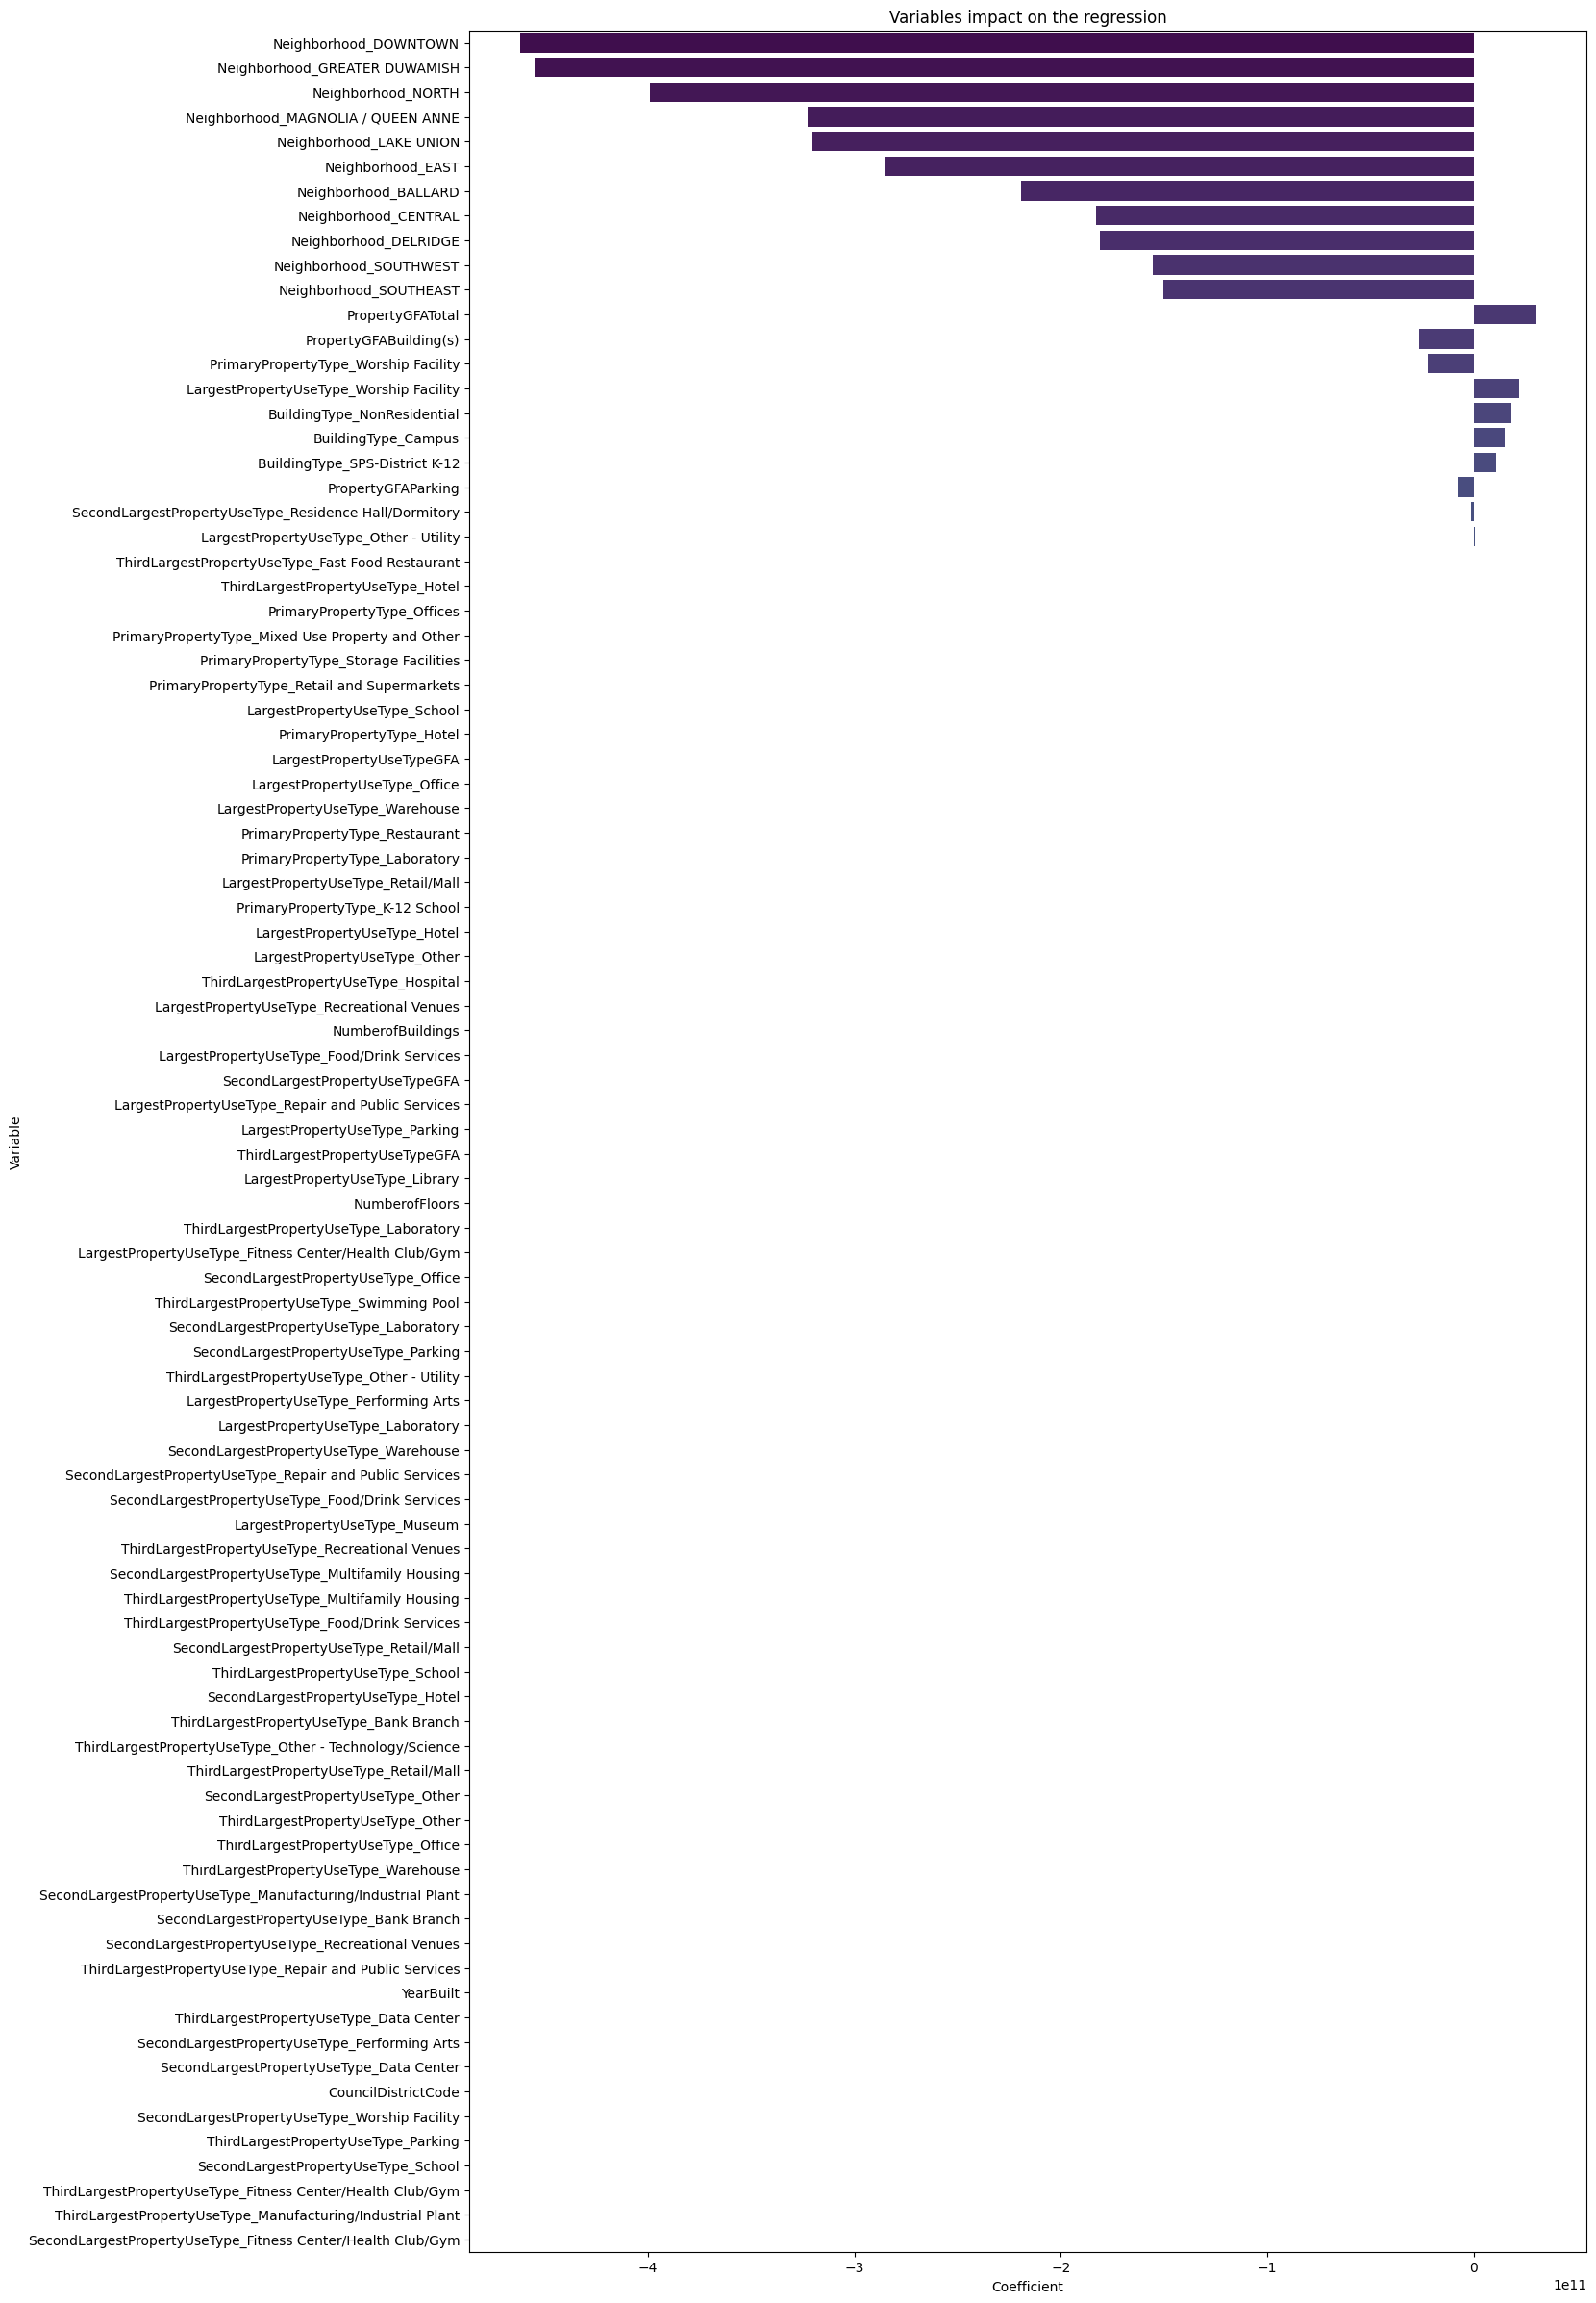

In [16]:
#Create a dataframle from the feature_coefficient tuple
df_coefficients = pd.DataFrame(feature_coefficients, columns=['Feature', 'Coefficient'])

# Sorting the dataframe by feature importance
df_coefficients_sorted = df_coefficients.reindex(df_coefficients['Coefficient'].abs().sort_values(ascending=False).index)

# Create the plot
plt.figure(figsize=(15, 30))
sns.barplot(x='Coefficient', y='Feature', data=df_coefficients_sorted, palette='viridis')
plt.title('Variables impact on the regression')
plt.xlabel('Coefficient')
plt.ylabel('Variable')
plt.show()

Very few variables seem to have an impact on the regression

- Neighborhood_DOWNTOWN: 473969379331.1985
- Neighborhood_GREATER DUWAMISH: 466860439529.8844
- Neighborhood_NORTH: 409524655582.1725
- Neighborhood_MAGNOLIA / QUEEN ANNE: 330835900323.2003
- Neighborhood_LAKE UNION: 328709867040.0459
- PropertyGFATotal: 311334418081.2454
- Neighborhood_EAST: 292775736003.5324
- PropertyGFABuilding(s): -269506191096.3441
- Neighborhood_BALLARD: 224739522181.83307
- BuildingType_NonResidential: 208712314223.8195
- Neighborhood_CENTRAL: 187729924170.80368
- Neighborhood_DELRIDGE: 185546196972.89236
- BuildingType_Campus: 171000726066.5945
- Neighborhood_SOUTHWEST: 159322752914.7445
- Neighborhood_SOUTHEAST: 154026737799.68933
- BuildingType_SPS-District K-12: 121330011177.74438
- PropertyGFAParking: -77540282712.57219
- PrimaryPropertyType_Worship Facility: -3602455874.040574
- LargestPropertyUseType_Worship Facility: 3602455873.255768

### 3.1.3 Main variables, location and and main property types variables

I will now try to reduce the number of variables sicne it seems that most of them are not useful to the model.

I will keep basic information about the buildings : YearBuilt, NumberofBuildings, NumberofFloors, BuildingType, PrimaryPropertyType
I will keep location information using Council district code and Neighborhood information
I will keep all information about Gross floor areas (GFA) since they give information the size attributed to different parts of the building (parking, hotel...)
Second and Third largest property use don't seem to be interesting and add a lot of columns du to encoding, I will not keep them.

In [17]:
#Using all columns except Site Energy Use to define X, the variables

X = data[['CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings','NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
          'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
          'BuildingType_Campus', 'BuildingType_NonResidential','BuildingType_SPS-District K-12', 'PrimaryPropertyType_Hotel',
          'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory','PrimaryPropertyType_Mixed Use Property and Other',
          'PrimaryPropertyType_Offices', 'PrimaryPropertyType_Restaurant','PrimaryPropertyType_Retail and Supermarkets',
          'PrimaryPropertyType_Storage Facilities','PrimaryPropertyType_Worship Facility', 'Neighborhood_BALLARD',
          'Neighborhood_CENTRAL', 'Neighborhood_DELRIDGE','Neighborhood_DOWNTOWN', 'Neighborhood_EAST',
          'Neighborhood_GREATER DUWAMISH', 'Neighborhood_LAKE UNION',
          'Neighborhood_MAGNOLIA / QUEEN ANNE', 'Neighborhood_NORTH',
          'Neighborhood_SOUTHEAST', 'Neighborhood_SOUTHWEST']]

#Using Site Energy Use to define y, the target
y = data['TotalGHGEmissions']

In [18]:
#Defining parameters for the test train split, using  70% of the data to train and 30% to test the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1033 entries, 544 to 1126
Data columns (total 33 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   CouncilDistrictCode                               1033 non-null   float64
 1   YearBuilt                                         1033 non-null   float64
 2   NumberofBuildings                                 1033 non-null   float64
 3   NumberofFloors                                    1033 non-null   float64
 4   PropertyGFATotal                                  1033 non-null   float64
 5   PropertyGFAParking                                1033 non-null   float64
 6   PropertyGFABuilding(s)                            1033 non-null   float64
 7   LargestPropertyUseTypeGFA                         1033 non-null   float64
 8   SecondLargestPropertyUseTypeGFA                   1033 non-null   float64
 9   ThirdLargestPropertyUs

In [20]:
print(y_train.info())

<class 'pandas.core.series.Series'>
Index: 1033 entries, 544 to 1126
Series name: TotalGHGEmissions
Non-Null Count  Dtype  
--------------  -----  
1033 non-null   float64
dtypes: float64(1)
memory usage: 16.1 KB
None


In [21]:
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 444 entries, 1233 to 714
Data columns (total 33 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   CouncilDistrictCode                               444 non-null    float64
 1   YearBuilt                                         444 non-null    float64
 2   NumberofBuildings                                 444 non-null    float64
 3   NumberofFloors                                    444 non-null    float64
 4   PropertyGFATotal                                  444 non-null    float64
 5   PropertyGFAParking                                444 non-null    float64
 6   PropertyGFABuilding(s)                            444 non-null    float64
 7   LargestPropertyUseTypeGFA                         444 non-null    float64
 8   SecondLargestPropertyUseTypeGFA                   444 non-null    float64
 9   ThirdLargestPropertyUse

In [22]:
print(y_test.info())

<class 'pandas.core.series.Series'>
Index: 444 entries, 1233 to 714
Series name: TotalGHGEmissions
Non-Null Count  Dtype  
--------------  -----  
444 non-null    float64
dtypes: float64(1)
memory usage: 6.9 KB
None


### 3.1.4 - 5 Folds Cross Validation

In [23]:
#Initiating the Linear Regression model
model = LinearRegression()

# Finding out how long the model takes
start_time = timeit.default_timer()

#Defining hyperparameters to search
#Testing with fit intercept true and false to see which one gives the best result
param_grid = {
    'fit_intercept': [True, False]
}

#Initiating cross validation search, with 5 folds
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_squared_error')

#Use the model and cross validation on the training data 
grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False]},
             scoring='neg_mean_squared_error')

In [24]:
# Function to calculate p-value
def calculate_p_value(y_true, y_pred, dof):
    residuals = y_true - y_pred
    rss = np.sum(residuals**2)
    mse_res = rss / dof
    mse_model = mean_squared_error(y_true, y_pred)
    f = mse_model / mse_res
    p_value = 1 - stats.f.cdf(f, X_test.shape[1], dof)
    return p_value

#Saving the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Use the model to predict y, based on X_Test
predictions = best_model.predict(X_test)

# Accessing results of the grid search
results = grid_search.cv_results_
intercepts = results['param_fit_intercept']
mean_squared_errors = -results['mean_test_score']

# Loop through each model's results
for i in range(len(intercepts)):
    # Extracting model parameters
    intercept = intercepts[i]
    mse = mean_squared_errors[i]
    r2 = r2_score(y_test, predictions)
    
    # Calculating p-value
    p_value = calculate_p_value(y_test, predictions, len(y_test) - X_test.shape[1] - 1)

    # Printing results
    print(f"Model {i+1}:")
    print(f"  Fit Intercept: {intercept}")
    print(f"  R2 Score: {r2}")
    print(f"  Mean Squared Error: {mse}")
    print(f"  P-value: {p_value}")

# For the best model
best_intercept = best_model.fit_intercept
best_predictions = best_model.predict(X_test)
best_mse = mean_squared_error(y_test, best_predictions)
best_r2 = r2_score(y_test, best_predictions)
best_p_value = calculate_p_value(y_test, best_predictions, len(y_test) - X_test.shape[1] - 1)

# Printing results for the best model
print("Best Model:")
print(f"  Fit Intercept: {best_intercept}")
print(f"  R2 Score: {best_r2}")
print(f"  Mean Squared Error: {best_mse}")
print(f"  P-value: {best_p_value}")

elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))

Model 1:
  Fit Intercept: True
  R2 Score: 0.48206070532916656
  Mean Squared Error: 0.4538220330032779
  P-value: 0.5926505138446819
Model 2:
  Fit Intercept: False
  R2 Score: 0.48206070532916656
  Mean Squared Error: 0.45380466182996565
  P-value: 0.5926505138446819
Best Model:
  Fit Intercept: False
  R2 Score: 0.48206070532916656
  Mean Squared Error: 0.8340730956735125
  P-value: 0.5926505138446819
Elapsed time : 0.15


The mean squared error is at 0.83 and the coefficient of determination is 0.48, which means that this model is way better than the previous one.

In [25]:
# Accessing the coefficients of the best model
coefficients = best_model.coef_

# Getting the names of the features
feature_names = X.columns

# Associating coefficients with feature names
feature_coefficients = list(zip(feature_names, coefficients))

# Displaying the impact of each variable on the regression
print("\nImpact of each variable on the regression:")
for feature, coefficient in feature_coefficients:
    print(f"{feature}: {coefficient}")


Impact of each variable on the regression:
CouncilDistrictCode: -0.02248426504610113
YearBuilt: 0.015870292305601864
NumberofBuildings: 0.1550435718941781
NumberofFloors: -0.08949719080651923
PropertyGFATotal: -2694515349809.8906
PropertyGFAParking: 671090216381.9387
PropertyGFABuilding(s): 2332503335977.2676
LargestPropertyUseTypeGFA: 0.5548811230213204
SecondLargestPropertyUseTypeGFA: -0.008259512103505388
ThirdLargestPropertyUseTypeGFA: -0.01915727260570714
BuildingType_Campus: 10096097038857.4
BuildingType_NonResidential: 12322636435989.598
BuildingType_SPS-District K-12: 7163475821147.53
PrimaryPropertyType_Hotel: -0.27216054991292543
PrimaryPropertyType_K-12 School: -0.31031258889316665
PrimaryPropertyType_Laboratory: -0.04309104820835546
PrimaryPropertyType_Mixed Use Property and Other: -0.6216760694375965
PrimaryPropertyType_Offices: -0.8187544962216479
PrimaryPropertyType_Restaurant: -0.1304753975283662
PrimaryPropertyType_Retail and Supermarkets: -0.4464220664163859
PrimaryP

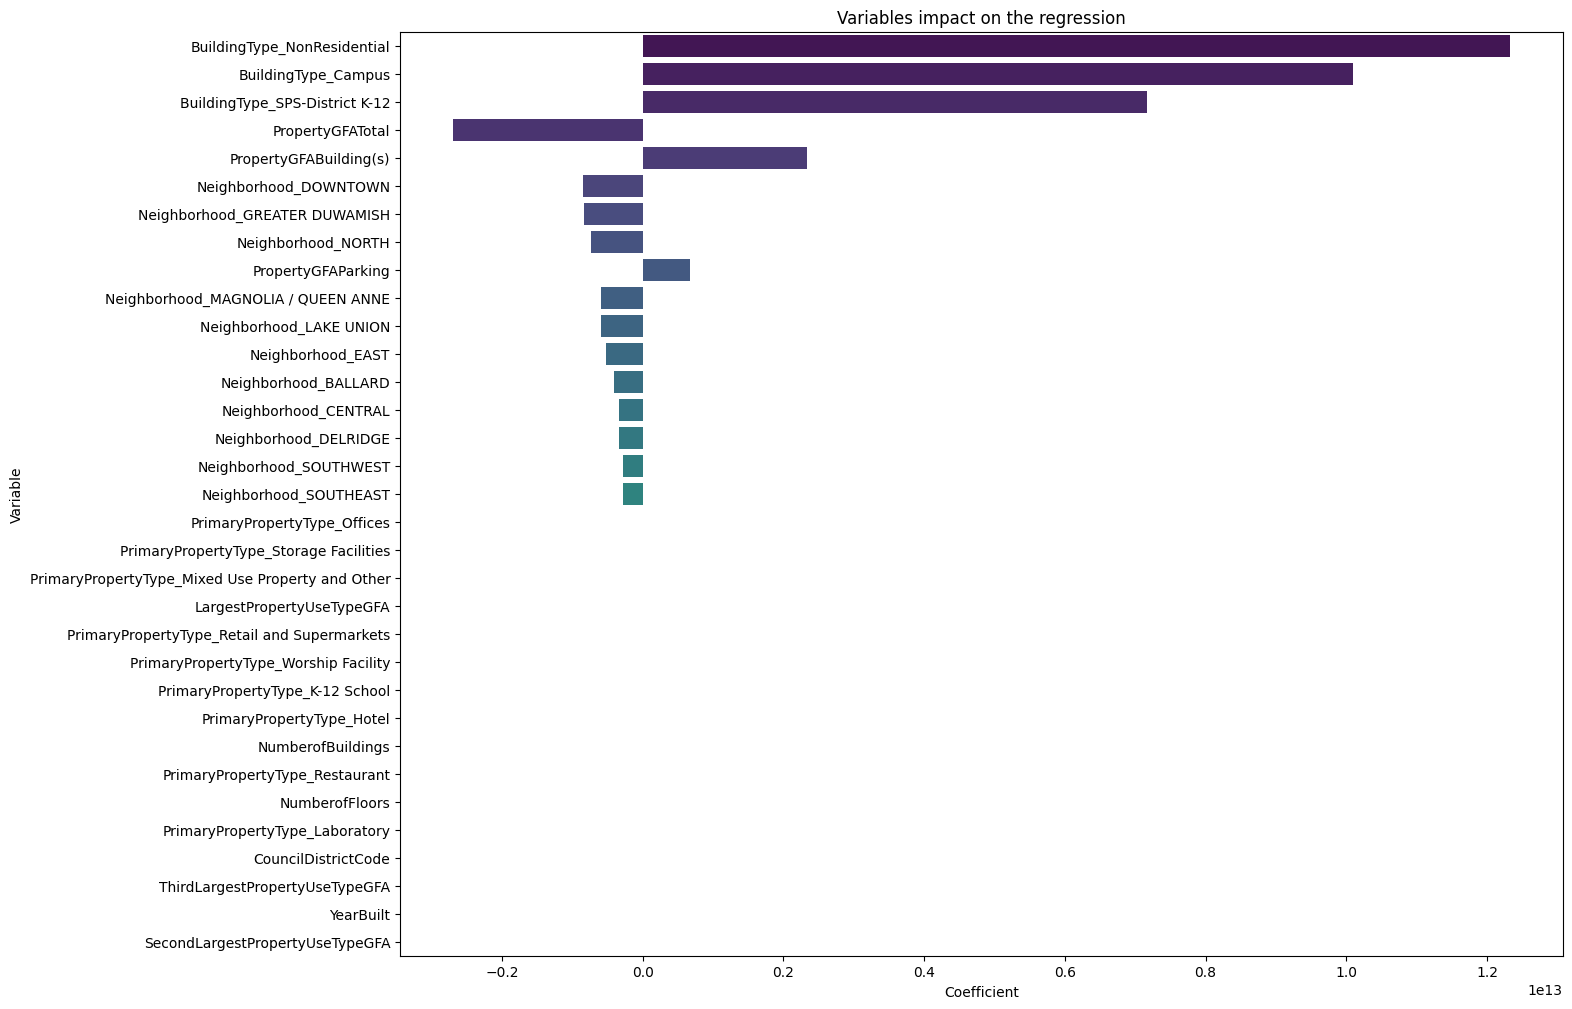

In [26]:
#Create a dataframle from the feature_coefficient tuple
df_coefficients = pd.DataFrame(feature_coefficients, columns=['Feature', 'Coefficient'])

# Sorting the dataframe by feature importance
df_coefficients_sorted = df_coefficients.reindex(df_coefficients['Coefficient'].abs().sort_values(ascending=False).index)

# Create the plot
plt.figure(figsize=(15, 12))
sns.barplot(x='Coefficient', y='Feature', data=df_coefficients_sorted, palette='viridis')
plt.title('Variables impact on the regression')
plt.xlabel('Coefficient')
plt.ylabel('Variable')
plt.show()

### 3.1.2 - 10 folds cross validation

Using a higher number of folds to see if the model's accuracy improves. Using the X data that yielded the best results with 5 folds.

In [27]:
#Using all columns except Site Energy Use to define X, the variables

X = data[['CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings','NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
          'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
          'BuildingType_Campus', 'BuildingType_NonResidential','BuildingType_SPS-District K-12', 'PrimaryPropertyType_Hotel',
          'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory','PrimaryPropertyType_Mixed Use Property and Other',
          'PrimaryPropertyType_Offices', 'PrimaryPropertyType_Restaurant','PrimaryPropertyType_Retail and Supermarkets',
          'PrimaryPropertyType_Storage Facilities','PrimaryPropertyType_Worship Facility', 'Neighborhood_BALLARD',
          'Neighborhood_CENTRAL', 'Neighborhood_DELRIDGE','Neighborhood_DOWNTOWN', 'Neighborhood_EAST',
          'Neighborhood_GREATER DUWAMISH', 'Neighborhood_LAKE UNION',
          'Neighborhood_MAGNOLIA / QUEEN ANNE', 'Neighborhood_NORTH',
          'Neighborhood_SOUTHEAST', 'Neighborhood_SOUTHWEST']]

#Using Site Energy Use to define y, the target
y = data['TotalGHGEmissions']

In [28]:
#Defining parameters for the test train split, using  70% of the data to train and 30% to test the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
#Initiating the Linear Regression model
model = LinearRegression()

#Defining hyperparameters to search
#Testing with fit intercept true and false to see which one gives the best result
param_grid = {
    'fit_intercept': [True, False]
}

#Initiating cross validation search, with 10 folds
cv = KFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_squared_error')

#Use the model and cross validation on the training data 
grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False]},
             scoring='neg_mean_squared_error')

In [30]:
#Saving the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Use the model to predict y, based on X_Test
predictions = best_model.predict(X_test)

#Evaluate the performances of the best model
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error :", mse)

#Calculating the coefficient of determination R2
r_squared = r2_score(y_test, predictions)
print("R2 :",r_squared)

Mean Squared Error : 0.8322758952070456
R2 : 0.4831767235136787


10 folds cross validation gives similar results than 5 folds cross validation with the same data (5 folds: 0,48, 10 folds : 0.48)

# 4. Random Forest testing  - GHG Emissions

Since the values to predict are not categories but continuous values, I need to use Random Forest Regressor.

In [31]:
#Using all columns except Site Energy Use to define X, the variables

X = data[['CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings','NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
          'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
          'BuildingType_Campus', 'BuildingType_NonResidential','BuildingType_SPS-District K-12', 'PrimaryPropertyType_Hotel',
          'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory','PrimaryPropertyType_Mixed Use Property and Other',
          'PrimaryPropertyType_Offices', 'PrimaryPropertyType_Restaurant','PrimaryPropertyType_Retail and Supermarkets',
          'PrimaryPropertyType_Storage Facilities','PrimaryPropertyType_Worship Facility', 'Neighborhood_BALLARD',
          'Neighborhood_CENTRAL', 'Neighborhood_DELRIDGE','Neighborhood_DOWNTOWN', 'Neighborhood_EAST',
          'Neighborhood_GREATER DUWAMISH', 'Neighborhood_LAKE UNION',
          'Neighborhood_MAGNOLIA / QUEEN ANNE', 'Neighborhood_NORTH',
          'Neighborhood_SOUTHEAST', 'Neighborhood_SOUTHWEST']]

#Using Site Energy Use to define y, the target
y = data['TotalGHGEmissions']

In [32]:
#Defining parameters for the test train split, using  70% of the data to train and 30% to test the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 4.1 - 1 000 estimators

I will start by creating a random forest regressor model with all variables included and look at its performance (MSE and R2). I will not define any hyperparameters and therefore use scikit learn default values for all parameters.

In [33]:
#Initiating the model
rfr = RandomForestRegressor(n_estimators=1000, random_state=42)

#Fitting it to the data
model = rfr.fit(X_train, y_train)

#Finding out how long the model takes
start_time = timeit.default_timer()

#Perform 5-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rfr, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')

#Calculate mean and standard deviation of the cross-validation scores
cv_mse_scores = -cv_scores  # Cross_val_score returns negative MSE scores, so we negate them
mean_cv_mse = np.mean(cv_mse_scores)
std_cv_mse = np.std(cv_mse_scores)

print("Cross-Validation Mean Squared Error: {:.2f} ± {:.2f}".format(mean_cv_mse, std_cv_mse))

#Evaluating the model on the test set
predictions = rfr.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Test Set Mean Squared Error: {:.2f}".format(mse))

#Calculating R-squared
r2 = r2_score(y_test, predictions)
print("R-squared: {:.2f}".format(r2))

elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))

Cross-Validation Mean Squared Error: 0.38 ± 0.19
Test Set Mean Squared Error: 0.76
R-squared: 0.53
Elapsed time : 29.30


### 4.1.1 Feature importances

Feature Importances:
NumberofBuildings: 0.2293
LargestPropertyUseTypeGFA: 0.1843
PropertyGFABuilding(s): 0.1217
PropertyGFATotal: 0.1059
NumberofFloors: 0.0718
YearBuilt: 0.0383
SecondLargestPropertyUseTypeGFA: 0.0323
PrimaryPropertyType_Offices: 0.0270
PrimaryPropertyType_Mixed Use Property and Other: 0.0259
PrimaryPropertyType_Hotel: 0.0184
CouncilDistrictCode: 0.0180
Neighborhood_EAST: 0.0174
ThirdLargestPropertyUseTypeGFA: 0.0171
Neighborhood_DOWNTOWN: 0.0158
BuildingType_Campus: 0.0156
Neighborhood_NORTH: 0.0116
PropertyGFAParking: 0.0105
PrimaryPropertyType_Laboratory: 0.0093
BuildingType_NonResidential: 0.0079
Neighborhood_CENTRAL: 0.0077
Neighborhood_LAKE UNION: 0.0045
Neighborhood_MAGNOLIA / QUEEN ANNE: 0.0021
PrimaryPropertyType_Retail and Supermarkets: 0.0020
PrimaryPropertyType_Storage Facilities: 0.0019
Neighborhood_GREATER DUWAMISH: 0.0014
Neighborhood_SOUTHWEST: 0.0006
Neighborhood_SOUTHEAST: 0.0005
PrimaryPropertyType_Restaurant: 0.0003
Neighborhood_DELRIDGE: 0.0002
Pri

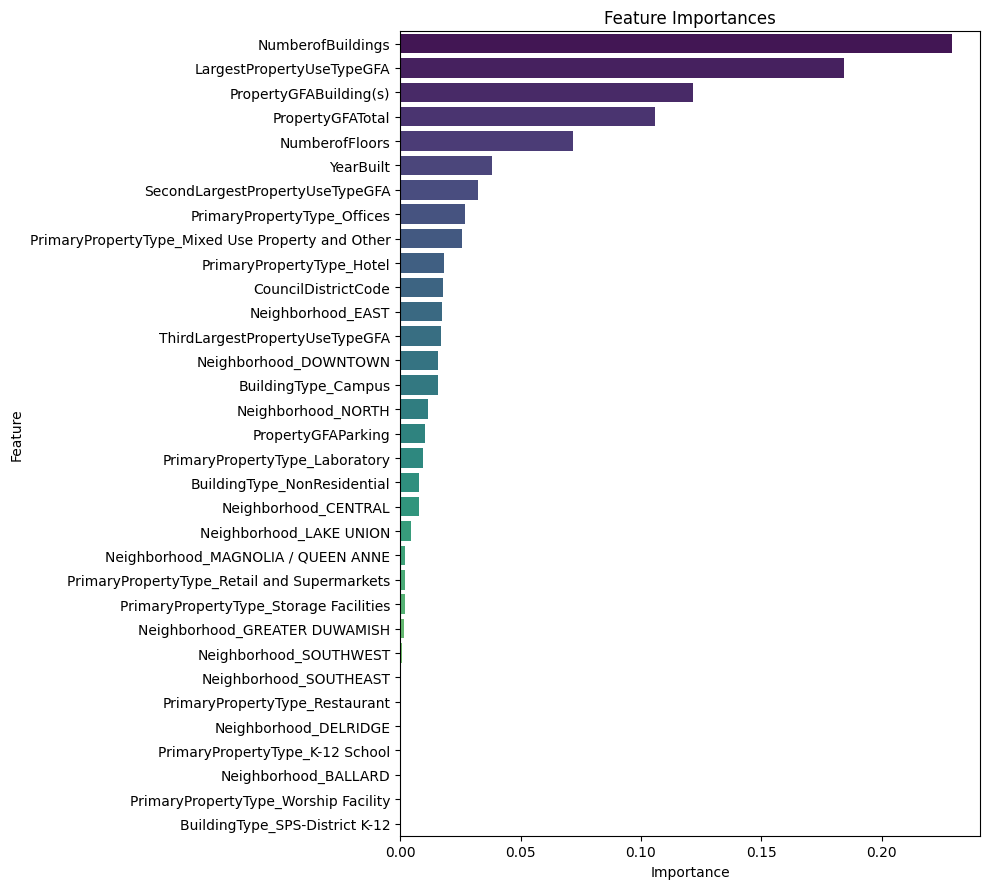

In [34]:
# Feature importances
importances = model.feature_importances_

# Indices of features sorted by importance in descending order
indices = np.argsort(importances)[::-1]

# Feature names
feature_names = X_train.columns

# Create a DataFrame for plotting
feature_importances = pd.DataFrame({
    'Feature': feature_names[indices],
    'Importance': importances[indices]
})


# Print feature importances
print("Feature Importances:")
for i in range(X_train.shape[1]):
    print(f"{feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# Plot with Seaborn
plt.figure(figsize=(10, 9))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

## 4.2 Variables/Features selection 

To see if the model can be improved, I will try several thresholds.

A threshold will select variables based on their importance to make a good prediction. The variables importance goes from 0 to 1, a threshold at 0.5 will select variables that have at least a 0.5 importance in the model's prediction.

#### 4.2.1 - Threshold at 0.05

In [35]:
# Initiating the model
rfr = RandomForestRegressor(n_estimators=1000, random_state=42)

# Fitting it to the data
model = rfr.fit(X_train, y_train)

# Features selection, selecting variable with an importance superior to 0.05
select = SelectFromModel(rfr, prefit=True, threshold=0.05)

# Get the selected feature indices
selected_feature_indices = select.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = X_train.columns[selected_feature_indices]

# Transform X_train and X_test to keep only selected features
X_train2 = select.transform(X_train)
X_test2 = select.transform(X_test)

print(selected_feature_names, X_train2.shape)

# Finding out how long the model takes
start_time = timeit.default_timer()

# Perform 5-fold cross-validation on the selected features
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rfr, X_train2, y_train, cv=cv, scoring='neg_mean_squared_error')

# Calculate mean and standard deviation of the cross-validation scores
cv_mse_scores = -cv_scores  # Cross_val_score returns negative MSE scores, so we negate them
mean_cv_mse = np.mean(cv_mse_scores)
std_cv_mse = np.std(cv_mse_scores)

print("Cross-Validation Mean Squared Error: {:.2f} ± {:.2f}".format(mean_cv_mse, std_cv_mse))

# Refitting the model on the entire training set with selected features
best_model = rfr.fit(X_train2, y_train)

# Using the best model to make prediction on the test set
predictions = best_model.predict(X_test2)
mse = mean_squared_error(y_test, predictions)
print("Test Set Mean Squared Error: {:.2f}".format(mse))

#Calculating R-squared
r2 = r2_score(y_test, predictions)
print("R-squared: {:.2f}".format(r2))

elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA'],
      dtype='object') (1033, 5)
Cross-Validation Mean Squared Error: 0.44 ± 0.18
Test Set Mean Squared Error: 0.75
R-squared: 0.53
Elapsed time : 19.62


With a threshold of 0,05, 5 variables are kept to make the prediction

This model's performances are higher than the previous one's.

#### Feature importances

Feature Importances:
NumberofBuildings: 0.2555
NumberofFloors: 0.1198
PropertyGFATotal: 0.1841
PropertyGFABuilding(s): 0.1829
LargestPropertyUseTypeGFA: 0.2577


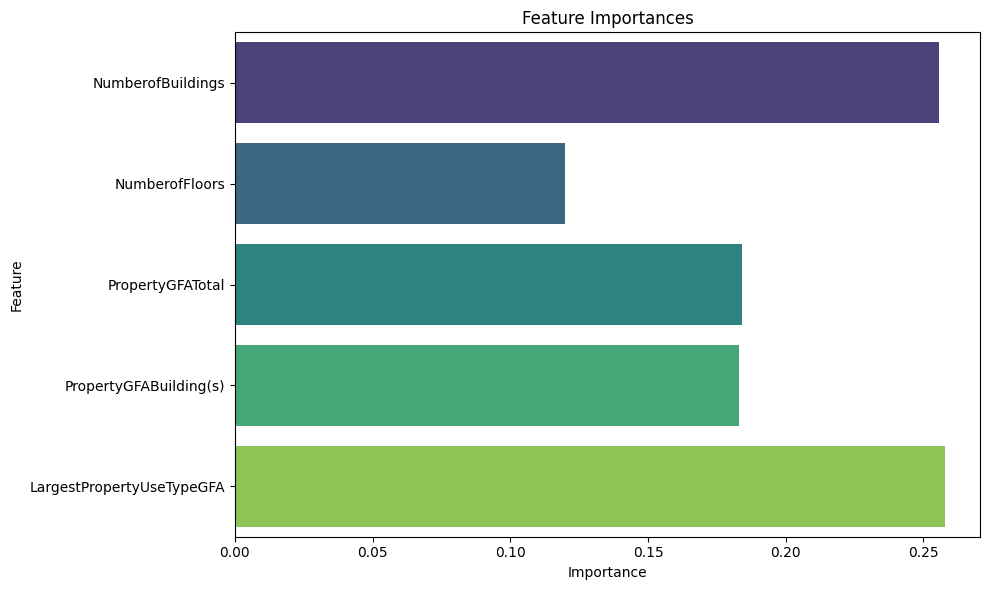

In [36]:
# Feature importances for the selected features
importances = best_model.feature_importances_

# Create a DataFrame for plotting
feature_importances = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': importances
})

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(selected_feature_names, importances):
    print(f"{feature}: {importance:.4f}")

# Plot with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

### 4.4.2 - Threshold at 0.005

In [37]:
#Initiating the model
rfr = RandomForestRegressor(n_estimators=1000, random_state=42)

#Fitting it to the data
model = rfr.fit(X_train, y_train)

#Features selection, selecting variable with an importance superior to 0.05
select = SelectFromModel(rfr, prefit=True, threshold=0.005)

#Get the selected feature indices
selected_feature_indices = select.get_support(indices=True)

#Get the names of the selected features
selected_feature_names = X_train.columns[selected_feature_indices]

#Transform X_train and X_test to keep only selected features
X_train2 = select.transform(X_train)
X_test2 = select.transform(X_test)

print(selected_feature_names, X_train2.shape)

#Finding out how long the model takes
start_time = timeit.default_timer()

#Perform 5-fold cross-validation on the selected features
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rfr, X_train2, y_train, cv=cv, scoring='neg_mean_squared_error')

#Calculate mean and standard deviation of the cross-validation scores
cv_mse_scores = -cv_scores  # Cross_val_score returns negative MSE scores, so we negate them
mean_cv_mse = np.mean(cv_mse_scores)
std_cv_mse = np.std(cv_mse_scores)

print("Cross-Validation Mean Squared Error: {:.2f} ± {:.2f}".format(mean_cv_mse, std_cv_mse))

# Refitting the model on the entire training set with selected features
best_model = rfr.fit(X_train2, y_train)

# Evaluating the model on the test set with selected features
predictions = best_model.predict(X_test2)
mse = mean_squared_error(y_test, predictions)
print("Test Set Mean Squared Error: {:.2f}".format(mse))

#Calculating R-squared
r2 = r2_score(y_test, predictions)
print("R-squared: {:.2f}".format(r2))

elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))

Index(['CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'BuildingType_Campus', 'BuildingType_NonResidential',
       'PrimaryPropertyType_Hotel', 'PrimaryPropertyType_Laboratory',
       'PrimaryPropertyType_Mixed Use Property and Other',
       'PrimaryPropertyType_Offices', 'Neighborhood_CENTRAL',
       'Neighborhood_DOWNTOWN', 'Neighborhood_EAST', 'Neighborhood_NORTH'],
      dtype='object') (1033, 20)
Cross-Validation Mean Squared Error: 0.39 ± 0.18
Test Set Mean Squared Error: 0.75
R-squared: 0.53
Elapsed time : 32.33


With a threshold of 0.005, 18 variables are kept to make the prediction

### Feature importances

Feature Importances:
CouncilDistrictCode: 0.0189
YearBuilt: 0.0397
NumberofBuildings: 0.2309
NumberofFloors: 0.0748
PropertyGFATotal: 0.1090
PropertyGFAParking: 0.0114
PropertyGFABuilding(s): 0.1216
LargestPropertyUseTypeGFA: 0.1854
SecondLargestPropertyUseTypeGFA: 0.0323
ThirdLargestPropertyUseTypeGFA: 0.0178
BuildingType_Campus: 0.0155
BuildingType_NonResidential: 0.0088
PrimaryPropertyType_Hotel: 0.0188
PrimaryPropertyType_Laboratory: 0.0095
PrimaryPropertyType_Mixed Use Property and Other: 0.0256
PrimaryPropertyType_Offices: 0.0267
Neighborhood_CENTRAL: 0.0076
Neighborhood_DOWNTOWN: 0.0158
Neighborhood_EAST: 0.0180
Neighborhood_NORTH: 0.0117


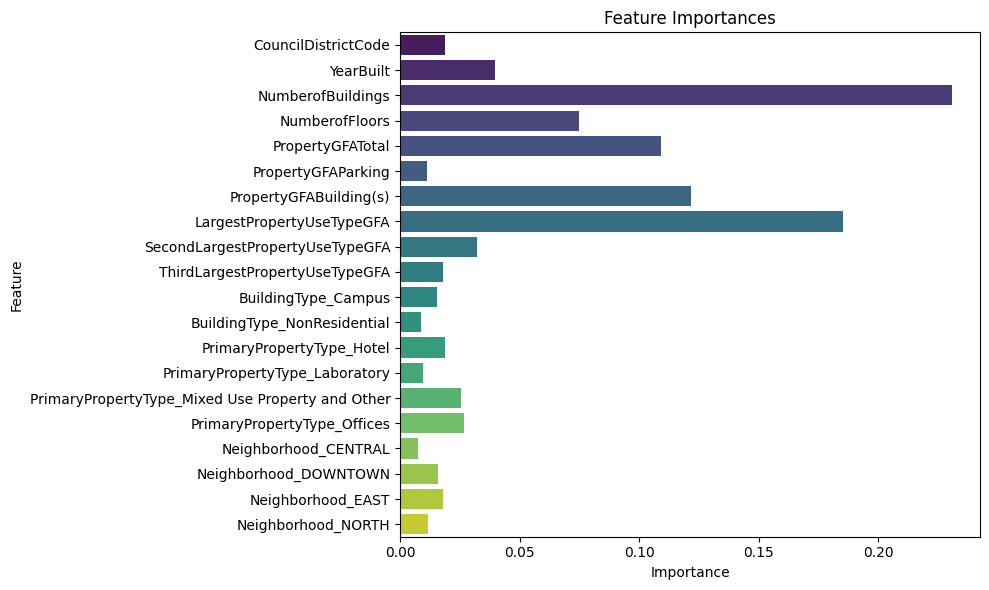

In [38]:
# Feature importances for the selected features
importances = best_model.feature_importances_

# Create a DataFrame for plotting
feature_importances = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': importances
})

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(selected_feature_names, importances):
    print(f"{feature}: {importance:.4f}")

# Plot with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

### 4.2.3 - 500 estimators

In [39]:
#Initiating the model
rfr = RandomForestRegressor(n_estimators=500, random_state=42)

#Fitting it to the data
model = rfr.fit(X_train, y_train)

#Features selection, selecting variable with an importance superior to 0.05
select = SelectFromModel(rfr, prefit=True, threshold=0.05)

#Get the selected feature indices
selected_feature_indices = select.get_support(indices=True)

#Get the names of the selected features
selected_feature_names = X_train.columns[selected_feature_indices]

#Transform X_train and X_test to keep only selected features
X_train2 = select.transform(X_train)
X_test2 = select.transform(X_test)

print(selected_feature_names, X_train2.shape)

#Finding out how long the model takes
start_time = timeit.default_timer()

#Perform 5-fold cross-validation on the selected features
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rfr, X_train2, y_train, cv=cv, scoring='neg_mean_squared_error')

#Calculate mean and standard deviation of the cross-validation scores
cv_mse_scores = -cv_scores  # Cross_val_score returns negative MSE scores, so we negate them
mean_cv_mse = np.mean(cv_mse_scores)
std_cv_mse = np.std(cv_mse_scores)

print("Cross-Validation Mean Squared Error: {:.2f} ± {:.2f}".format(mean_cv_mse, std_cv_mse))

#Refitting the model on the entire training set with selected features
best_model = rfr.fit(X_train2, y_train)

#Evaluating the model on the test set with selected features
predictions = best_model.predict(X_test2)
mse = mean_squared_error(y_test, predictions)
print("Test Set Mean Squared Error: {:.2f}".format(mse))

#Calculating R-squared
r2 = r2_score(y_test, predictions)
print("R-squared: {:.2f}".format(r2))

elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA'],
      dtype='object') (1033, 5)
Cross-Validation Mean Squared Error: 0.44 ± 0.17
Test Set Mean Squared Error: 0.75
R-squared: 0.53
Elapsed time : 9.80


## 4.3 Grid search

In [40]:
#Using all columns except Site Energy Use to define X, the variables

X = data[['CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings','NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
          'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
          'BuildingType_Campus', 'BuildingType_NonResidential','BuildingType_SPS-District K-12', 'PrimaryPropertyType_Hotel',
          'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory','PrimaryPropertyType_Mixed Use Property and Other',
          'PrimaryPropertyType_Offices', 'PrimaryPropertyType_Restaurant','PrimaryPropertyType_Retail and Supermarkets',
          'PrimaryPropertyType_Storage Facilities','PrimaryPropertyType_Worship Facility', 'Neighborhood_BALLARD',
          'Neighborhood_CENTRAL', 'Neighborhood_DELRIDGE','Neighborhood_DOWNTOWN', 'Neighborhood_EAST',
          'Neighborhood_GREATER DUWAMISH', 'Neighborhood_LAKE UNION',
          'Neighborhood_MAGNOLIA / QUEEN ANNE', 'Neighborhood_NORTH',
          'Neighborhood_SOUTHEAST', 'Neighborhood_SOUTHWEST']]

#Using Site Energy Use to define y, the target
y = data['TotalGHGEmissions']

In [41]:
#Defining parameters for the test train split, using  70% of the data to train and 30% to test the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [42]:
#Finding out how long the model takes
start_time = timeit.default_timer()

#Initiating the model
rfr = RandomForestRegressor(random_state = 42)

#Fitting it to the data
model = rfr.fit(X_train, y_train)

#Features selection, selecting variable with an importance supérior to 0.05
select = SelectFromModel(rfr, prefit = True, threshold = 0.05)

X_train3 = select.transform(X_train)

#Transforming X_test to get the same number of variables than X_train
X_test3 = select.transform(X_test)


#Hyperparameters to test
param_grid = {
    'n_estimators': [200,500,600],  # Number of trees in the forest
    'max_depth': [None,1,2,3,10],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10], # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4], # Minimum number of samples required to be at a leaf node
    'random_state' : [42]
}


#Instantiating the grid search and cross validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, scoring='neg_mean_squared_error', cv =cv)

#Traning the model on the new X_train with grid search
grid_search.fit(X_train3, y_train)

#Display the best parameters
print("Best parameters:")
print(grid_search.best_params_)

#Create a variable containing the best model
best_model = grid_search.best_estimator_

#Use the best model to make predictions
predictions = best_model.predict(X_test3)

#Displaying the time spent
elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))

#Evaluate the best model's performances
mse = mean_squared_error(y_test, predictions)
print("Best model Mean Squared Error (MSE) : {:.2f}".format(mse))

#Calculating R-squared
r2 = r2_score(y_test, predictions)
print("Best model R-squared : {:.2f}".format(r2))

Best parameters:
{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 42}
Elapsed time : 461.99
Best model Mean Squared Error (MSE) : 0.79
Best model R-squared : 0.51


## 4.4 Randomized search

In [43]:
#Using all columns except Site Energy Use to define X, the variables

X = data[['CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings','NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
          'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
          'BuildingType_Campus', 'BuildingType_NonResidential','BuildingType_SPS-District K-12', 'PrimaryPropertyType_Hotel',
          'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory','PrimaryPropertyType_Mixed Use Property and Other',
          'PrimaryPropertyType_Offices', 'PrimaryPropertyType_Restaurant','PrimaryPropertyType_Retail and Supermarkets',
          'PrimaryPropertyType_Storage Facilities','PrimaryPropertyType_Worship Facility', 'Neighborhood_BALLARD',
          'Neighborhood_CENTRAL', 'Neighborhood_DELRIDGE','Neighborhood_DOWNTOWN', 'Neighborhood_EAST',
          'Neighborhood_GREATER DUWAMISH', 'Neighborhood_LAKE UNION',
          'Neighborhood_MAGNOLIA / QUEEN ANNE', 'Neighborhood_NORTH',
          'Neighborhood_SOUTHEAST', 'Neighborhood_SOUTHWEST']]

#Using Site Energy Use to define y, the target
y = data['TotalGHGEmissions']

In [44]:
#Defining parameters for the test train split, using  70% of the data to train and 30% to test the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [45]:
#Finding out how long the model takes
start_time = timeit.default_timer()

#Initiating the model
rfr = RandomForestRegressor(random_state = 42)

#Fitting it to the data
model = rfr.fit(X_train, y_train)

#Features selection, selecting variable with an importance supérior to 0.05
select = SelectFromModel(rfr, prefit = True, threshold = 0.05)

X_train3 = select.transform(X_train)

#Transforming X_test to get the same number of variables than X_train
X_test3 = select.transform(X_test)


# Hyperparameters to test
param_distributions = {
    'n_estimators': [200,500,600,700],  # Number of trees in the forest
    'max_depth': randint(1,10),  # Maximum depth of each tree
    'min_samples_split': randint(2,12),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1,5),  # Minimum number of samples required to be at a leaf node
    'random_state' : [42]
}


# Instantiating the grid search and cross validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(estimator=rfr, param_distributions=param_distributions,n_iter=300, scoring='neg_mean_squared_error', cv = cv)

#Traning the model on the new X_train with grid search
random_search.fit(X_train3, y_train)

# Display the best parameters
print("Best parameters:")
print(random_search.best_params_)

# Create a variable containing the best model
best_model = random_search.best_estimator_

# Use the best model to make predictions
predictions = best_model.predict(X_test3)

#Displaying the time spent
elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))

# Evaluate the best model's performances
mse = mean_squared_error(y_test, predictions)
print("Best model Mean Squared Error (MSE) : {:.2f}".format(mse))

#Calculating R-squared
r2 = r2_score(y_test, predictions)
print("Best model R-squared : {:.2f}".format(r2))

Best parameters:
{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 700, 'random_state': 42}
Elapsed time : 1274.26
Best model Mean Squared Error (MSE) : 0.81
Best model R-squared : 0.49


# 5. Gradient Boosting testing - GHG Emissions

Trying Gradient Boosting Regressor to evaluate if it gives better predictions than Random Forest

## 5.1 With LargestPropertyUseTypeGFA but not the categories

In [7]:
#Using all columns except Site Energy Use to define X, the variables

X = data[['CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings','NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
          'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
          'BuildingType_Campus', 'BuildingType_NonResidential','BuildingType_SPS-District K-12', 'PrimaryPropertyType_Hotel',
          'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory','PrimaryPropertyType_Mixed Use Property and Other',
          'PrimaryPropertyType_Offices', 'PrimaryPropertyType_Restaurant','PrimaryPropertyType_Retail and Supermarkets',
          'PrimaryPropertyType_Storage Facilities','PrimaryPropertyType_Worship Facility', 'Neighborhood_BALLARD',
          'Neighborhood_CENTRAL', 'Neighborhood_DELRIDGE','Neighborhood_DOWNTOWN', 'Neighborhood_EAST',
          'Neighborhood_GREATER DUWAMISH', 'Neighborhood_LAKE UNION',
          'Neighborhood_MAGNOLIA / QUEEN ANNE', 'Neighborhood_NORTH',
          'Neighborhood_SOUTHEAST', 'Neighborhood_SOUTHWEST']]

#Using Site Energy Use to define y, the target
y = data['TotalGHGEmissions']

In [8]:
#Defining parameters for the test train split, using  70% of the data to train and 30% to test the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
#Initiating the model
model = GradientBoostingRegressor()

#Finding out how long the model takes
start_time = timeit.default_timer()

#Defining the cross validation parameters
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#Defining a variety of possibility for the model parameters
param_grid = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'subsample': uniform(0.4, 0.7)
}

#Looking for the best parameters using cross validation and 120 iterations
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=120, cv=kf, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)

#Obtaining the best parameters
best_params = random_search.best_params_

#Display the best parameters
print("Best parameters:")
print(random_search.best_params_)

#Training the model with the best parameters
best_model = GradientBoostingRegressor(**best_params)
best_model.fit(X_train, y_train)

predictions = best_model.predict(X_test)

#Looking at the model best parameters
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

#Calculating R-squared
r2 = r2_score(y_test, predictions)
print("R2 : {:.2f}".format(r2))

elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))

Best parameters:
{'learning_rate': 0.019915219870164515, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 102, 'subsample': 0.7426169321942941}
Mean Squared Error: 0.7569825536640699
R2 : 0.53
Elapsed time : 152.37


In [10]:
#Taking a look at variables with that are the most important in the model
feature_importances = best_model.feature_importances_

#Associating each variable name with its importance
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, feature_importances))

sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

sorted_features

[('NumberofBuildings', 0.30344534655040706),
 ('LargestPropertyUseTypeGFA', 0.21354049942216113),
 ('PropertyGFABuilding(s)', 0.10794525506197306),
 ('NumberofFloors', 0.07635407579341104),
 ('PropertyGFATotal', 0.0724229448660522),
 ('PrimaryPropertyType_Mixed Use Property and Other', 0.03977123994537599),
 ('PrimaryPropertyType_Offices', 0.028989684874930335),
 ('YearBuilt', 0.02682685130355885),
 ('BuildingType_Campus', 0.021349360781709483),
 ('Neighborhood_DOWNTOWN', 0.02036030799298758),
 ('SecondLargestPropertyUseTypeGFA', 0.015099840620833008),
 ('Neighborhood_NORTH', 0.015099350693758002),
 ('PrimaryPropertyType_Hotel', 0.014955210499272783),
 ('Neighborhood_EAST', 0.011868260834069711),
 ('ThirdLargestPropertyUseTypeGFA', 0.011504662236560081),
 ('CouncilDistrictCode', 0.008481709635449336),
 ('PrimaryPropertyType_Laboratory', 0.007935206767216136),
 ('Neighborhood_CENTRAL', 0.0014800967796369606),
 ('Neighborhood_LAKE UNION', 0.0012495815871764778),
 ('BuildingType_NonReside

## 5.2 Threshold at 0.05

In [50]:
#Initiating the model
gbr2 = GradientBoostingRegressor()

# Fitting it to the data
model = gbr2.fit(X_train, y_train)

#Finding out how long the model takes
start_time = timeit.default_timer()


#Defining a variety of possibility for the model parameters
param_grid = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'subsample': uniform(0.4, 0.7)
}


#Features selection, selecting variable with an importance superior to 0.05
select = SelectFromModel(gbr2, prefit=True, threshold=0.05)

#Get the selected feature indices
selected_feature_indices = select.get_support(indices=True)

#Transform X_train and X_test to keep only selected features
X_train2 = select.transform(X_train)
X_test2 = select.transform(X_test)

#Get the names of the selected features
selected_feature_names = X_train.columns[selected_feature_indices]

#Displaying the selected features
print(selected_feature_names, X_train2.shape)

#Defining the cross validation parameters
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(gbr2, X_train2, y_train, cv=cv, scoring='neg_mean_squared_error')


#Looking for the best parameters using cross validation and 120 iterations
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=130, cv=cv, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train2, y_train)

#Create a variable containing the best model
best_model = random_search.best_estimator_

#Display the best parameters
print("Best parameters:")
print(random_search.best_params_)

#Calculate mean and standard deviation of the cross-validation scores
cv_mse_scores = -cv_scores  # Cross_val_score returns negative MSE scores, so we negate them
mean_cv_mse = np.mean(cv_mse_scores)
std_cv_mse = np.std(cv_mse_scores)

print("Cross-Validation Mean Squared Error: {:.2f} ± {:.2f}".format(mean_cv_mse, std_cv_mse))

# Evaluating the model on the test set with selected features
predictions = best_model.predict(X_test2)
mse = mean_squared_error(y_test, predictions)
print("Test Set Mean Squared Error: {:.2f}".format(mse))

#Calculating R-squared
r2 = r2_score(y_test, predictions)
print("R-squared: {:.2f}".format(r2))

#Displaying the model's execution time
elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))


Index(['NumberofBuildings', 'PropertyGFATotal', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA'],
      dtype='object') (1033, 4)
Best parameters:
{'learning_rate': 0.019915219870164515, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 102, 'subsample': 0.7426169321942941}
Cross-Validation Mean Squared Error: 0.48 ± 0.18
Test Set Mean Squared Error: 0.74
R-squared: 0.54
Elapsed time : 249.88


In [12]:
# Initiating the model
gbr3 = GradientBoostingRegressor()

# Fitting it to the data
model = gbr3.fit(X_train, y_train)

#Finding out how long the model takes
start_time = timeit.default_timer()


#Defining a variety of possibility for the model parameters
param_grid = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'subsample': uniform(0.4, 0.7)
}


#Features selection, selecting variable with an importance superior to 0.05
select = SelectFromModel(gbr3, prefit=True, threshold=0.05)

#Get the selected feature indices
selected_feature_indices = select.get_support(indices=True)

#Transform X_train and X_test to keep only selected features
X_train3 = select.transform(X_train)
X_test3 = select.transform(X_test)

#Get the names of the selected features
selected_feature_names = X_train.columns[selected_feature_indices]

#Displaying the selected features
print(selected_feature_names, X_train3.shape)

#Defining the cross validation parameters
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(gbr3, X_train3, y_train, cv=cv, scoring='neg_mean_squared_error')


#Looking for the best parameters using cross validation and 400 iterations
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=400, cv=cv, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train3, y_train)

#Create a variable containing the best model
best_model = random_search.best_estimator_

#Display the best parameters
print("Best parameters:")
print(random_search.best_params_)

#Calculate mean and standard deviation of the cross-validation scores
cv_mse_scores = -cv_scores  # Cross_val_score returns negative MSE scores, so we negate them
mean_cv_mse = np.mean(cv_mse_scores)
std_cv_mse = np.std(cv_mse_scores)

print("Cross-Validation Mean Squared Error: {:.2f} ± {:.2f}".format(mean_cv_mse, std_cv_mse))

#Evaluating the model on the test set with selected features
predictions = best_model.predict(X_test3)
mse = mean_squared_error(y_test, predictions)
print("Test Set Mean Squared Error: {:.2f}".format(mse))

#Calculating R-squared
r2 = r2_score(y_test, predictions)
print("R-squared: {:.2f}".format(r2))

#Displaying the model's execution time
elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))


Index(['NumberofBuildings', 'PropertyGFATotal', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA'],
      dtype='object') (1033, 4)
Best parameters:
{'learning_rate': 0.019915219870164515, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 102, 'subsample': 0.7426169321942941}
Cross-Validation Mean Squared Error: 0.47 ± 0.20
Test Set Mean Squared Error: 0.74
R-squared: 0.54
Elapsed time : 677.41


# 6. SVR  - GHG Emissions

Since this is not a classification issue, I can't use support vector machine to try to predict a building's energy consumption. I will use a variation called support vector regression.

In [6]:
#Using all columns except Site Energy Use to define X, the variables

X = data[['CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings','NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
          'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
          'BuildingType_Campus', 'BuildingType_NonResidential','BuildingType_SPS-District K-12', 'PrimaryPropertyType_Hotel',
          'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory','PrimaryPropertyType_Mixed Use Property and Other',
          'PrimaryPropertyType_Offices', 'PrimaryPropertyType_Restaurant','PrimaryPropertyType_Retail and Supermarkets',
          'PrimaryPropertyType_Storage Facilities','PrimaryPropertyType_Worship Facility', 'Neighborhood_BALLARD',
          'Neighborhood_CENTRAL', 'Neighborhood_DELRIDGE','Neighborhood_DOWNTOWN', 'Neighborhood_EAST',
          'Neighborhood_GREATER DUWAMISH', 'Neighborhood_LAKE UNION',
          'Neighborhood_MAGNOLIA / QUEEN ANNE', 'Neighborhood_NORTH',
          'Neighborhood_SOUTHEAST', 'Neighborhood_SOUTHWEST']]

#Using Site Energy Use to define y, the target
y = data['TotalGHGEmissions']

In [7]:
#Defining parameters for the test train split, using  70% of the data to train and 30% to test the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 6.1 RBF

RBF Kernel : Gaussian Radial Basis Function

In [8]:
#Finding out how long the model takes
start_time = timeit.default_timer()

#Defining a variety of possibility for the model parameters
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2, 0.5, 1]
}

#Initialising the model
svr = SVR(kernel='rbf')

#Cross validation and grid search
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(svr, param_grid, cv=cv, scoring='neg_mean_squared_error')

#Training the model with the grid search
grid_search.fit(X_train, y_train)

#Best parameters and best score display
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

#Predictions with the best model
best_svr = grid_search.best_estimator_
predictions = best_svr.predict(X_test)

#Model's evaluation
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

#Displaying the model's execution time
elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))

Best Parameters: {'C': 10, 'epsilon': 0.01}
Best Score: -0.4729259149878894
Mean Squared Error: 1.2425884341160045
R2 Score: 0.22838252370137324
Elapsed time : 5.83


## 6.2 Linear SVR

In [9]:
#Finding out how long the model takes
start_time = timeit.default_timer()

#Defining a variety of possibility for the model parameters
param_grid_linear_svr = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2, 0.5, 1]
}

#Initialising the model
linear_svr = LinearSVR(random_state=42)

#Cross validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)


#GridSearchCV
grid_search_linear_svr = GridSearchCV(linear_svr, param_grid_linear_svr, cv=cv, scoring='neg_mean_squared_error')
grid_search_linear_svr.fit(X_train, y_train)

#Best parameters and best score display
print(f"LinearSVR - Best Parameters: {grid_search_linear_svr.best_params_}")
print(f"LinearSVR - Best Score: {grid_search_linear_svr.best_score_}")

#Predictions with the best model
best_linear_svr = grid_search_linear_svr.best_estimator_
predictions_linear_svr = best_linear_svr.predict(X_test)

#Model's evaluation
mse_linear_svr = mean_squared_error(y_test, predictions_linear_svr)
r2_linear_svr = r2_score(y_test, predictions_linear_svr)

print(f"LinearSVR - Mean Squared Error: {mse_linear_svr}")
print(f"LinearSVR - R2 Score: {r2_linear_svr}")

#Displaying the model's execution time
elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))

LinearSVR - Best Parameters: {'C': 1, 'epsilon': 0.2}
LinearSVR - Best Score: -0.5264537010237146
LinearSVR - Mean Squared Error: 1.1941196553539315
LinearSVR - R2 Score: 0.25848046741374464
Elapsed time : 5.24


# 7. SHAP

Using the SHAP method to explain the random forest regressor's predictions, global and local features importances.

Since the best performance (R2 and MSE) was given by 500 estimators, random forest regressor (rfr) with a threshold of 0.05 (5 variables), I will use the shap method on this model.

NumberofBuildings
PropertyGFATotal
PropertyGFABuilding(s)
LargestPropertyUseTypeGFA
NumberofFloors

Cross-validated scores: [-0.42164414 -0.7839365  -0.32906096 -0.30763783 -0.34678719]
Average cross-validated score: -0.4378133238539424


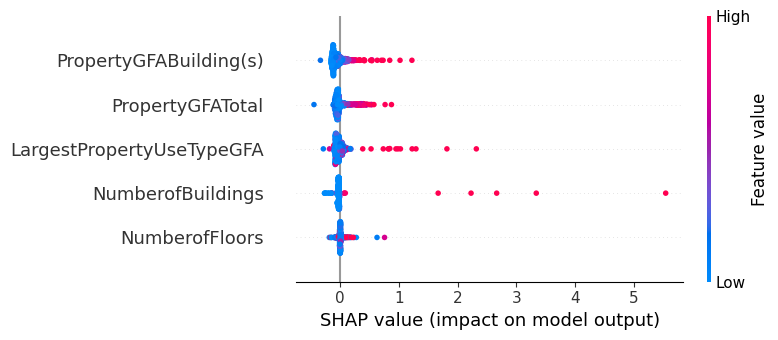

In [7]:
# Creating a dataframe that only contains the 4 features needed by the rfr
X = data[['NumberofBuildings', 'PropertyGFATotal', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA','NumberofFloors']]

# Using Site Energy Use to define y, the target
y = data['TotalGHGEmissions']

# Defining parameters for the test train split, using 70% of the data to train and 30% to test the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiating the model
rfr = RandomForestRegressor(n_estimators=500, random_state=42)

# Perform 5-fold cross-validation on the selected features
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rfr, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
print(f'Cross-validated scores: {cv_scores}')
print(f'Average cross-validated score: {cv_scores.mean()}')

# Fitting the model to the entire training data
rfr.fit(X_train, y_train)

# SHAP

# Initialising the JavaScript visualizations
shap.initjs()

# Initialising SHAP explainer
explainer = shap.TreeExplainer(rfr)

# Calculating SHAP values
shap_values = explainer.shap_values(X_test)

# Visualising global feature importances
shap.summary_plot(shap_values, X_test)

In [8]:
# Visualising local feature importances for the first 5 lines
for i in range(5):
    display(shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i]))

# 8. Energy Star Score

## 8.1 Random Forest

In [9]:
# Creating a dataframe that only contains the 4 features needed by the rfr
X = data[['NumberofBuildings', 'PropertyGFATotal', 'PropertyGFABuilding(s)','LargestPropertyUseTypeGFA','NumberofFloors','ENERGYSTARScore']]

# Using Site Energy Use to define y, the target
y = data['TotalGHGEmissions']

# Defining parameters for the test train split, using 70% of the data to train and 30% to test the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Finding out how long the model takes
start_time = timeit.default_timer()

# Initiating the model
rfr = RandomForestRegressor(n_estimators=500, random_state=42)

# Fitting it to the data
rfr.fit(X_train, y_train)

# Perform 5-fold cross-validation on the selected features
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rfr, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
print(f'Cross-validated scores: {cv_scores}')
print(f'Average cross-validated score: {cv_scores.mean()}')

# Calculate mean and standard deviation of the cross-validation scores
cv_mse_scores = -cv_scores  # Cross_val_score returns negative MSE scores, so we negate them
mean_cv_mse = np.mean(cv_mse_scores)
std_cv_mse = np.std(cv_mse_scores)

print("Cross-Validation Mean Squared Error: {:.2f} ± {:.2f}".format(mean_cv_mse, std_cv_mse))

# Evaluating the model on the test set
predictions = rfr.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Test Set Mean Squared Error: {:.2f}".format(mse))

# Calcul du coefficient de détermination (R-squared)
r2 = r2_score(y_test, predictions)
print("R-squared: {:.2f}".format(r2))

elapsed = timeit.default_timer() - start_time
print("Elapsed time : {:.2f}".format(elapsed))

Cross-validated scores: [-0.37705945 -0.6490758  -0.24968097 -0.21210815 -0.2285143 ]
Average cross-validated score: -0.343287732011652
Cross-Validation Mean Squared Error: 0.34 ± 0.16
Test Set Mean Squared Error: 0.76
R-squared: 0.53
Elapsed time : 11.49


## 8.2 Energy star score feature importance

Cross-validated scores: [-0.37705945 -0.6490758  -0.24968097 -0.21210815 -0.2285143 ]
Average cross-validated score: -0.343287732011652


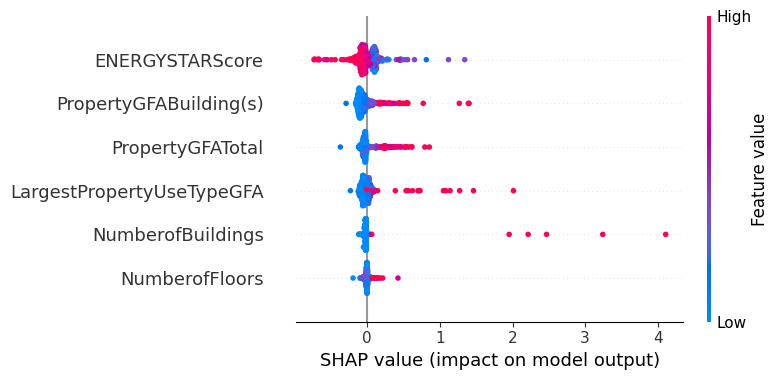

In [10]:
# Creating a dataframe that only contains the 4 features needed by the rfr
X = data[['NumberofBuildings', 'PropertyGFATotal', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA','NumberofFloors','ENERGYSTARScore']]

# Using Site Energy Use to define y, the target
y = data['TotalGHGEmissions']

# Defining parameters for the test train split, using 70% of the data to train and 30% to test the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiating the model
rfr = RandomForestRegressor(n_estimators=500, random_state=42)

# Perform 5-fold cross-validation on the selected features
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rfr, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
print(f'Cross-validated scores: {cv_scores}')
print(f'Average cross-validated score: {cv_scores.mean()}')

# Fitting the model to the entire training data
rfr.fit(X_train, y_train)

# SHAP

# Initialising the JavaScript visualizations
shap.initjs()

# Initialising SHAP explainer
explainer = shap.TreeExplainer(rfr)

# Calculating SHAP values
shap_values = explainer.shap_values(X_test)

# Visualising global feature importances
shap.summary_plot(shap_values, X_test)

In [11]:
# Visualising local feature importances for the first 5 lines
for i in range(5):
    display(shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i]))